In [238]:
#Подгрузим необходимые бибилиотеки
import pandas as pd 
import numpy as np 
from warnings import filterwarnings
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [195]:
filterwarnings("ignore")

1. Прочитайте исходный файл с данными.Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде. Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [196]:
#Прочитаем данные
df = pd.read_csv('ghana_gdp.csv',parse_dates=['year'],index_col='year')
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


 Визуализируем исходный временной ряд, а также сделаем его декомпозицию:

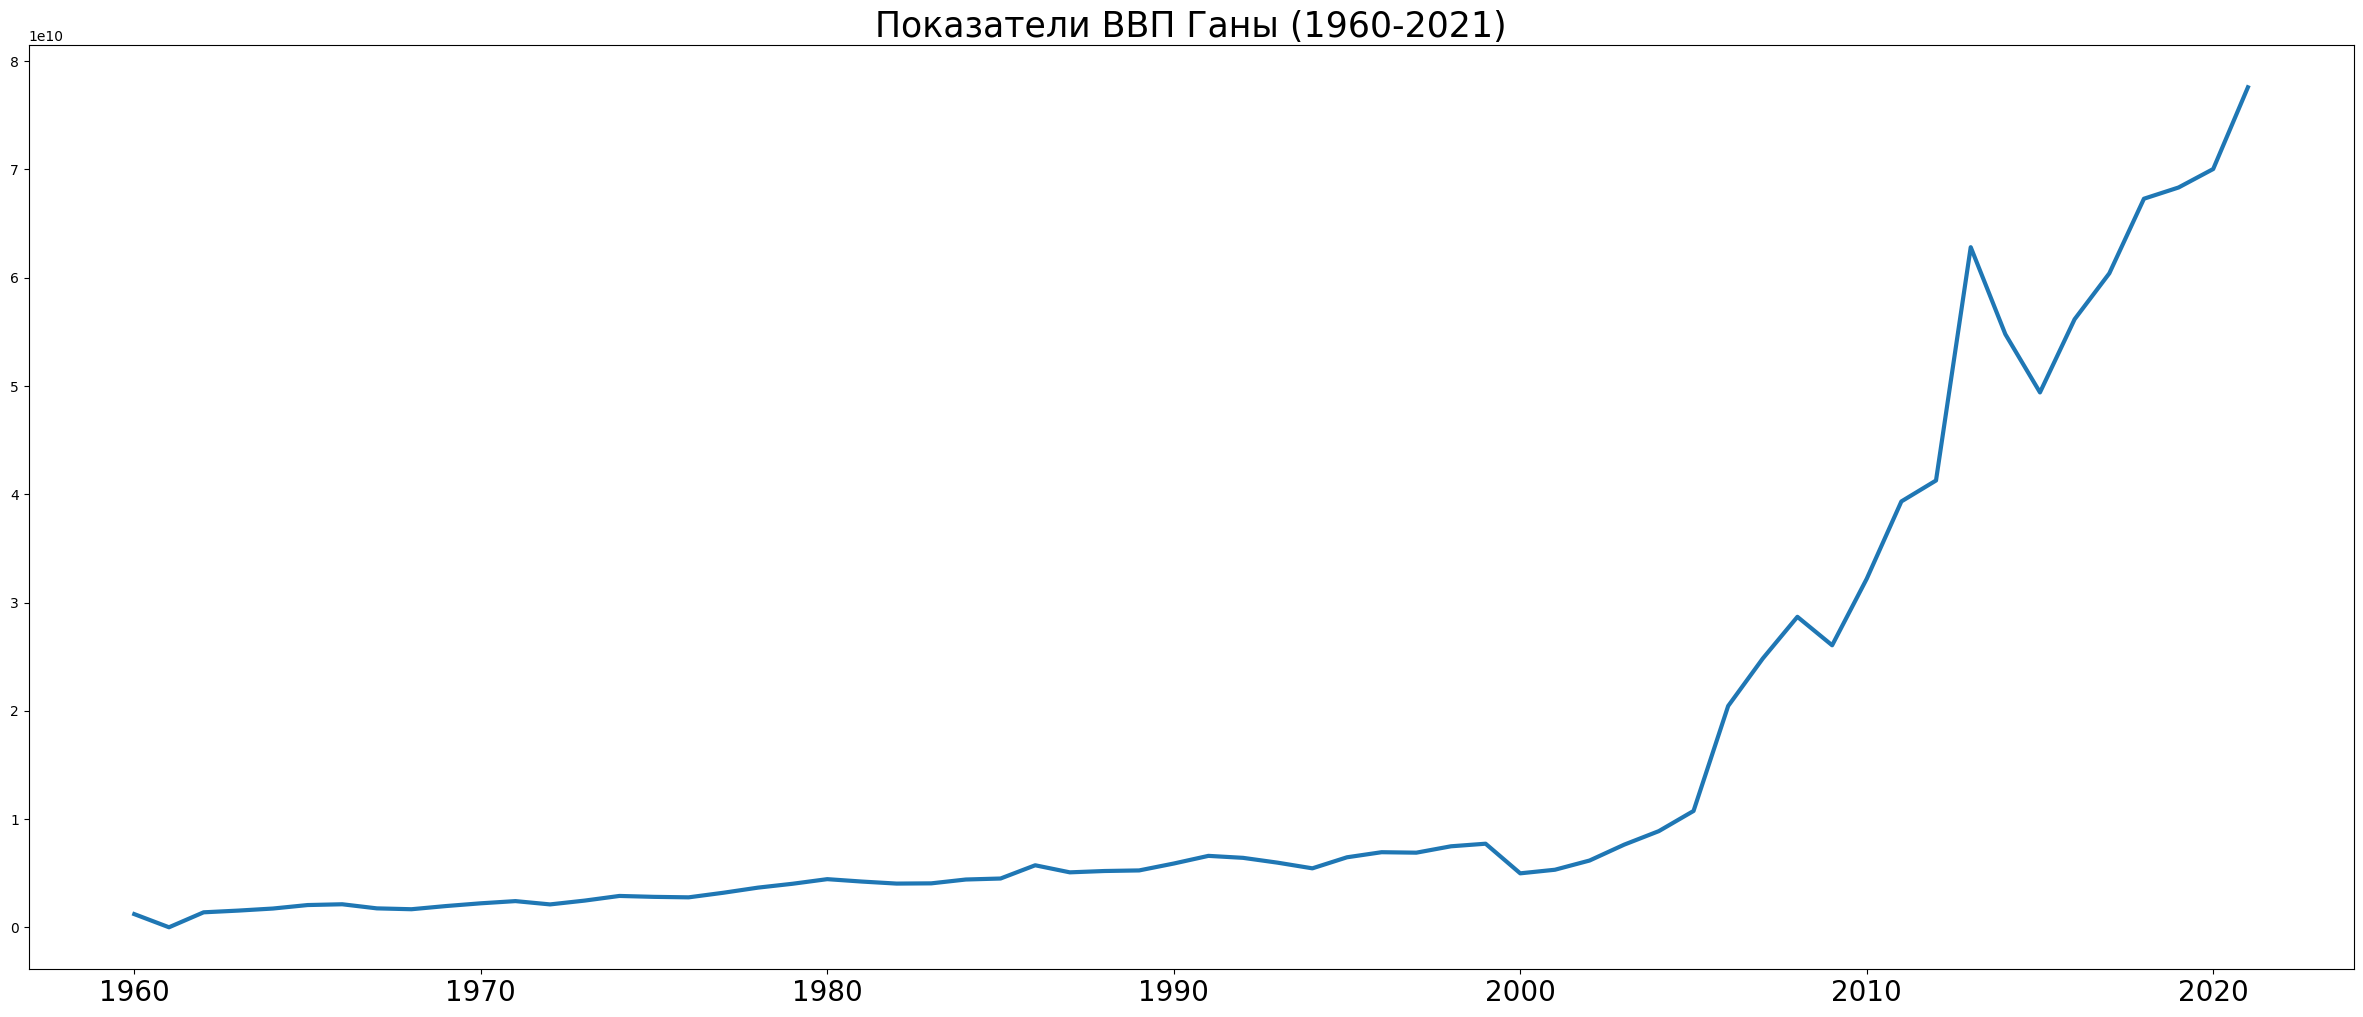

In [197]:
#Строим график
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

plt.plot(df)
plt.title('Показатели ВВП Ганы (1960-2021)',fontsize=25)
plt.xticks(fontsize=20)
plt.show()

График показывает, что данные у нас распределены между 1960 и 2021 годом. С 1960 по 2000 показатели практически стабильны с небольшим увеличением, однако после 2000 года ВВП начинает расти вверх. 

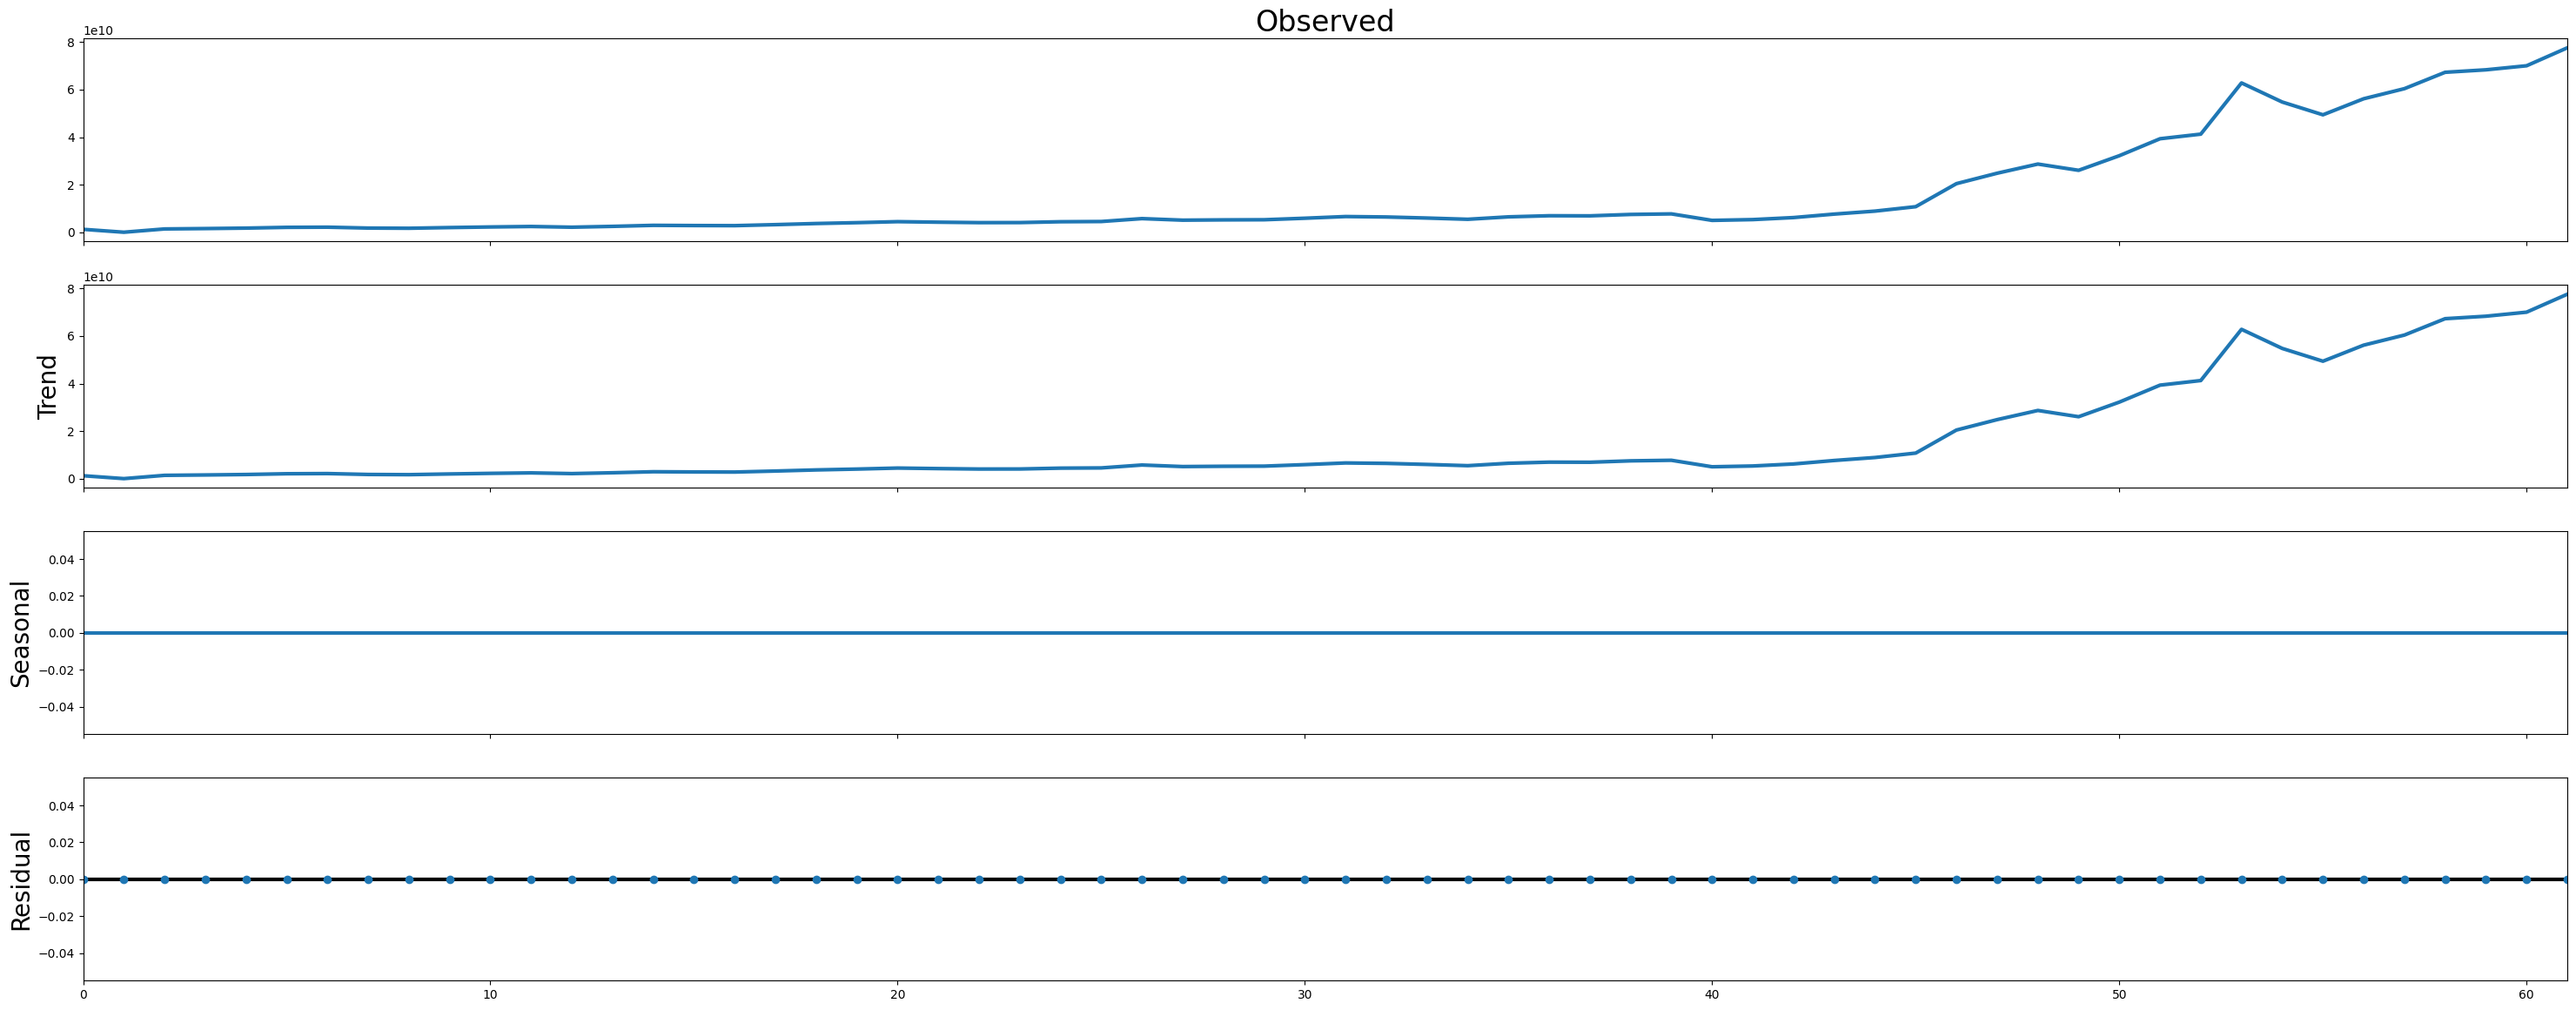

In [198]:
decompose = seasonal_decompose(df.values, model='additive',period=1)
decompose.plot()
plt.show()

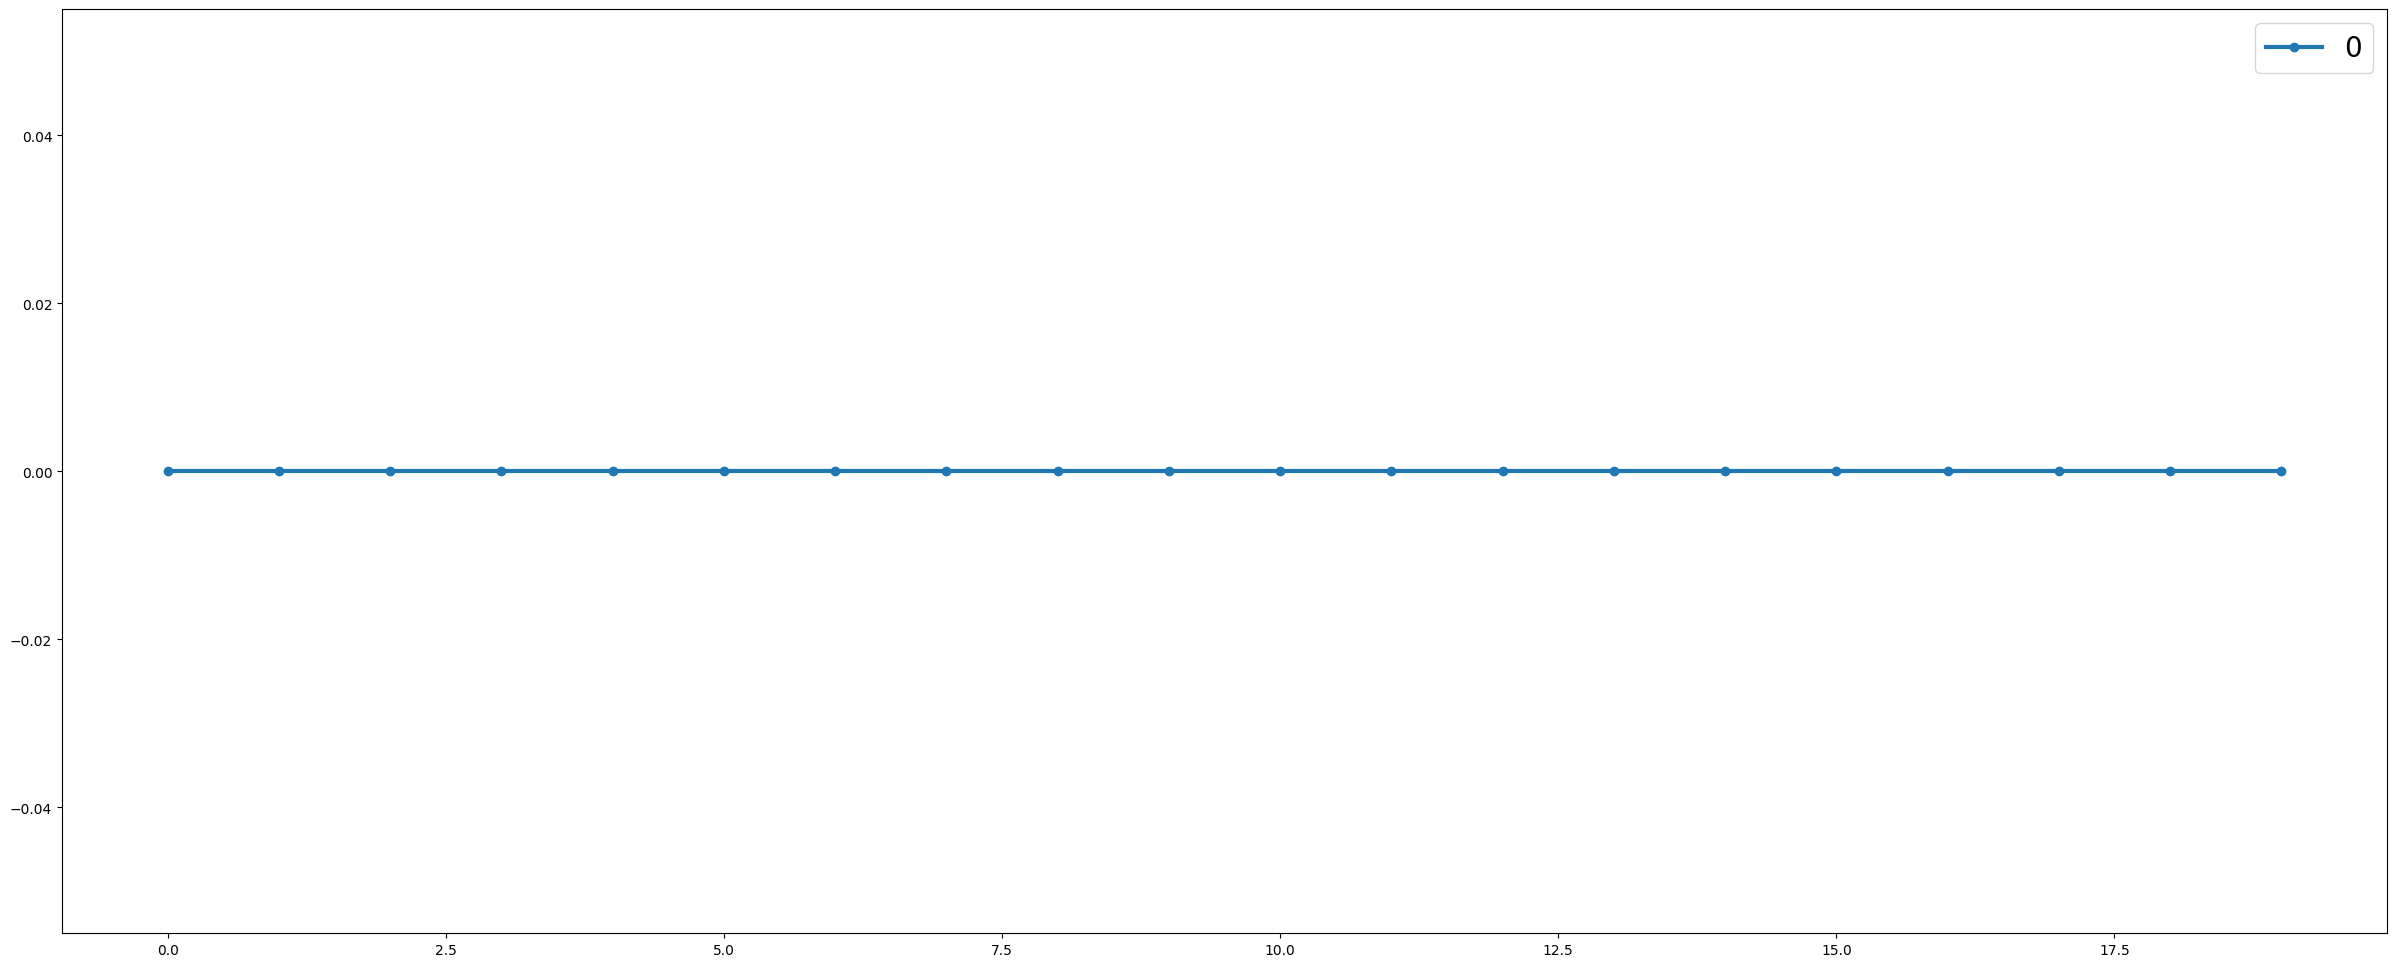

In [199]:
pd.DataFrame(decompose.seasonal[:20]).plot(marker='o')
plt.show()

Графики декомпозиции говорят о наличии тренда и отсутствии сезонности

In [200]:
#Разделим данные на обучающую и тестовую выборки 
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

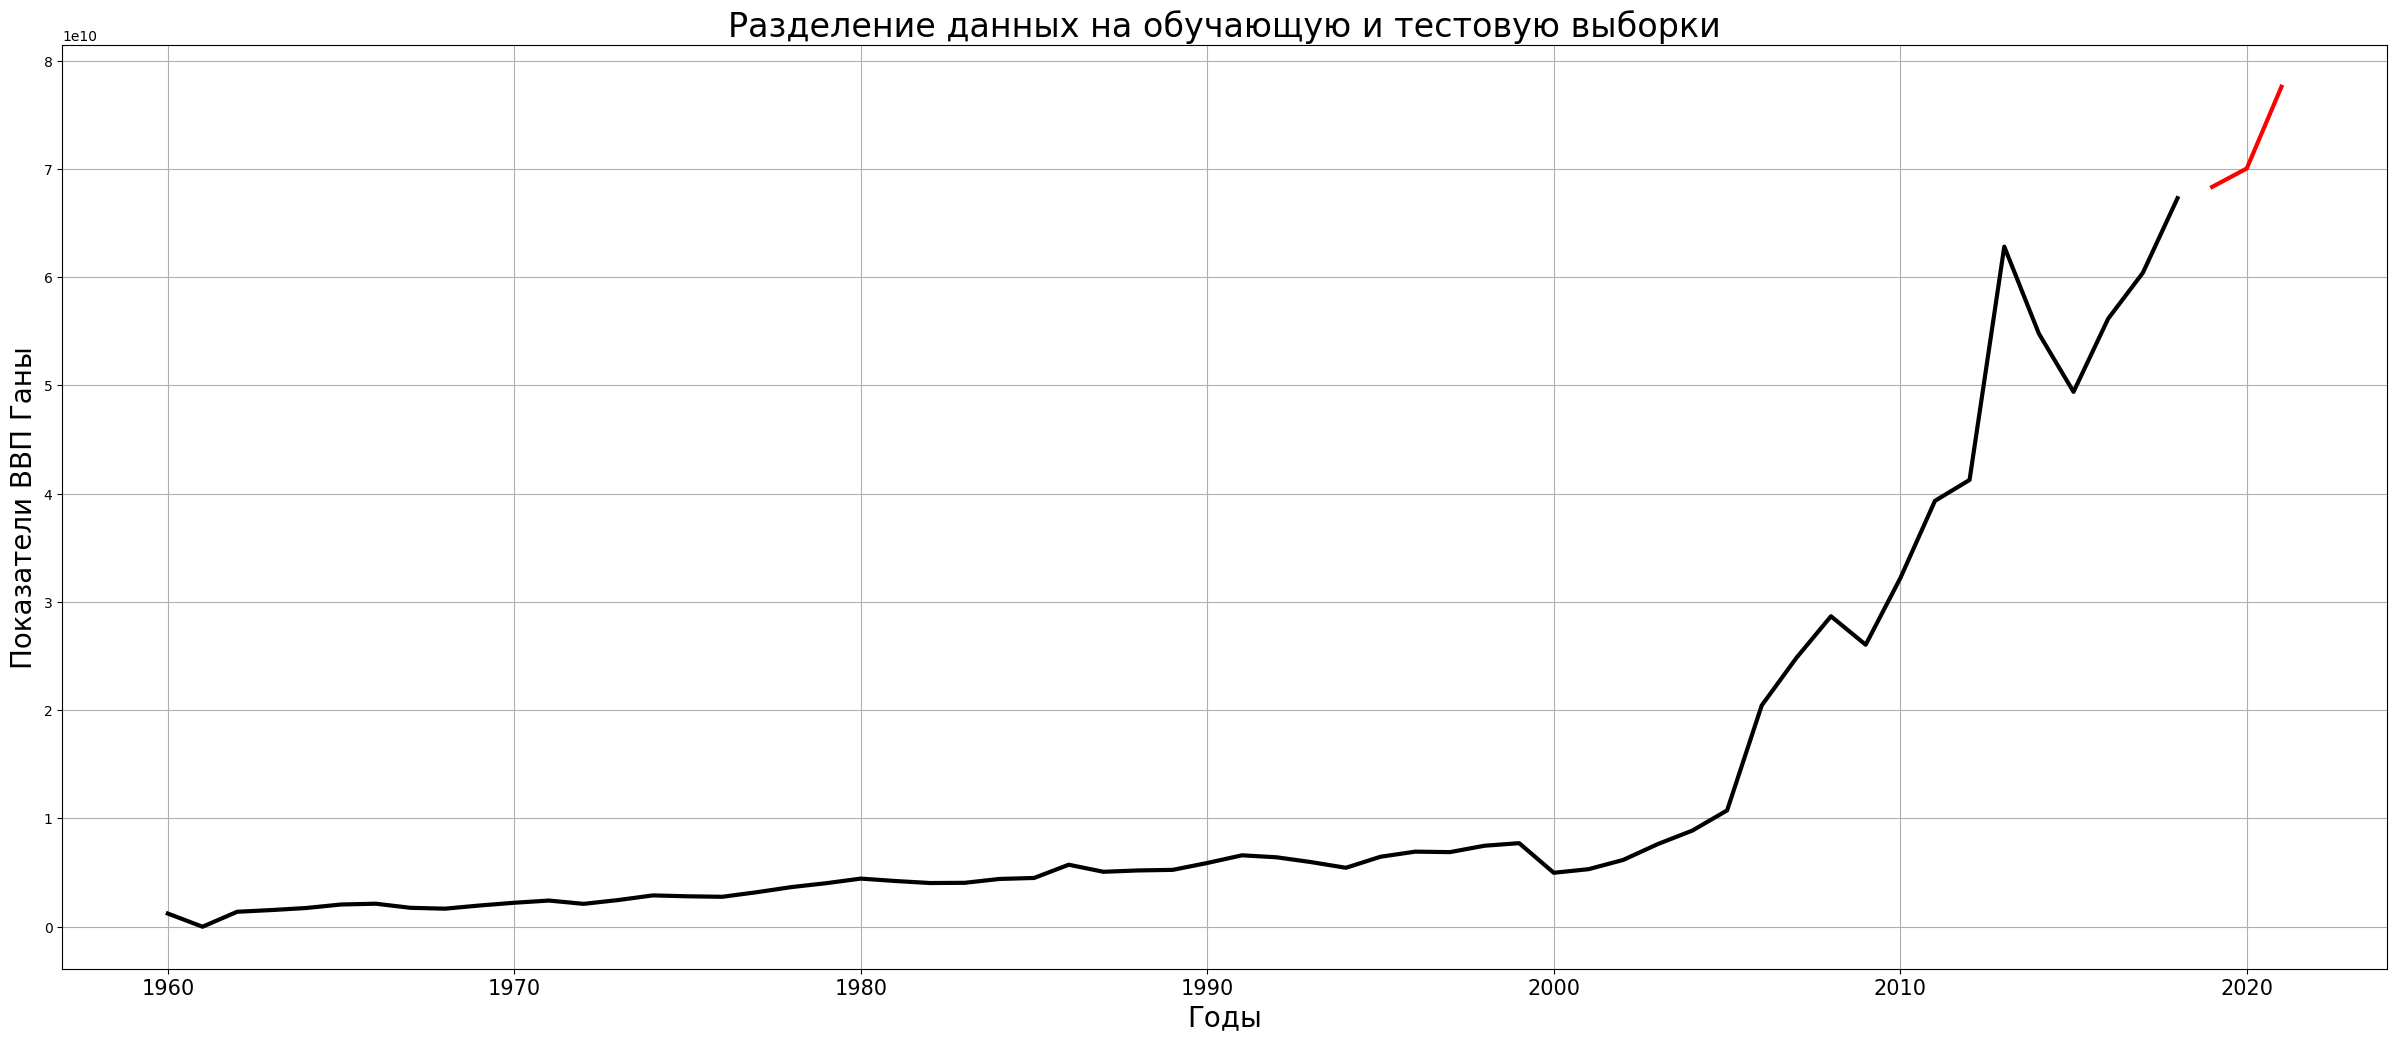

In [201]:
plt.plot(train_df, color = "black")
plt.plot(test_df, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Показатели ВВП Ганы')
plt.xlabel('Годы')
plt.xticks(fontsize=15)
 
# добавим сетку
plt.grid()
 
plt.show()

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.


Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

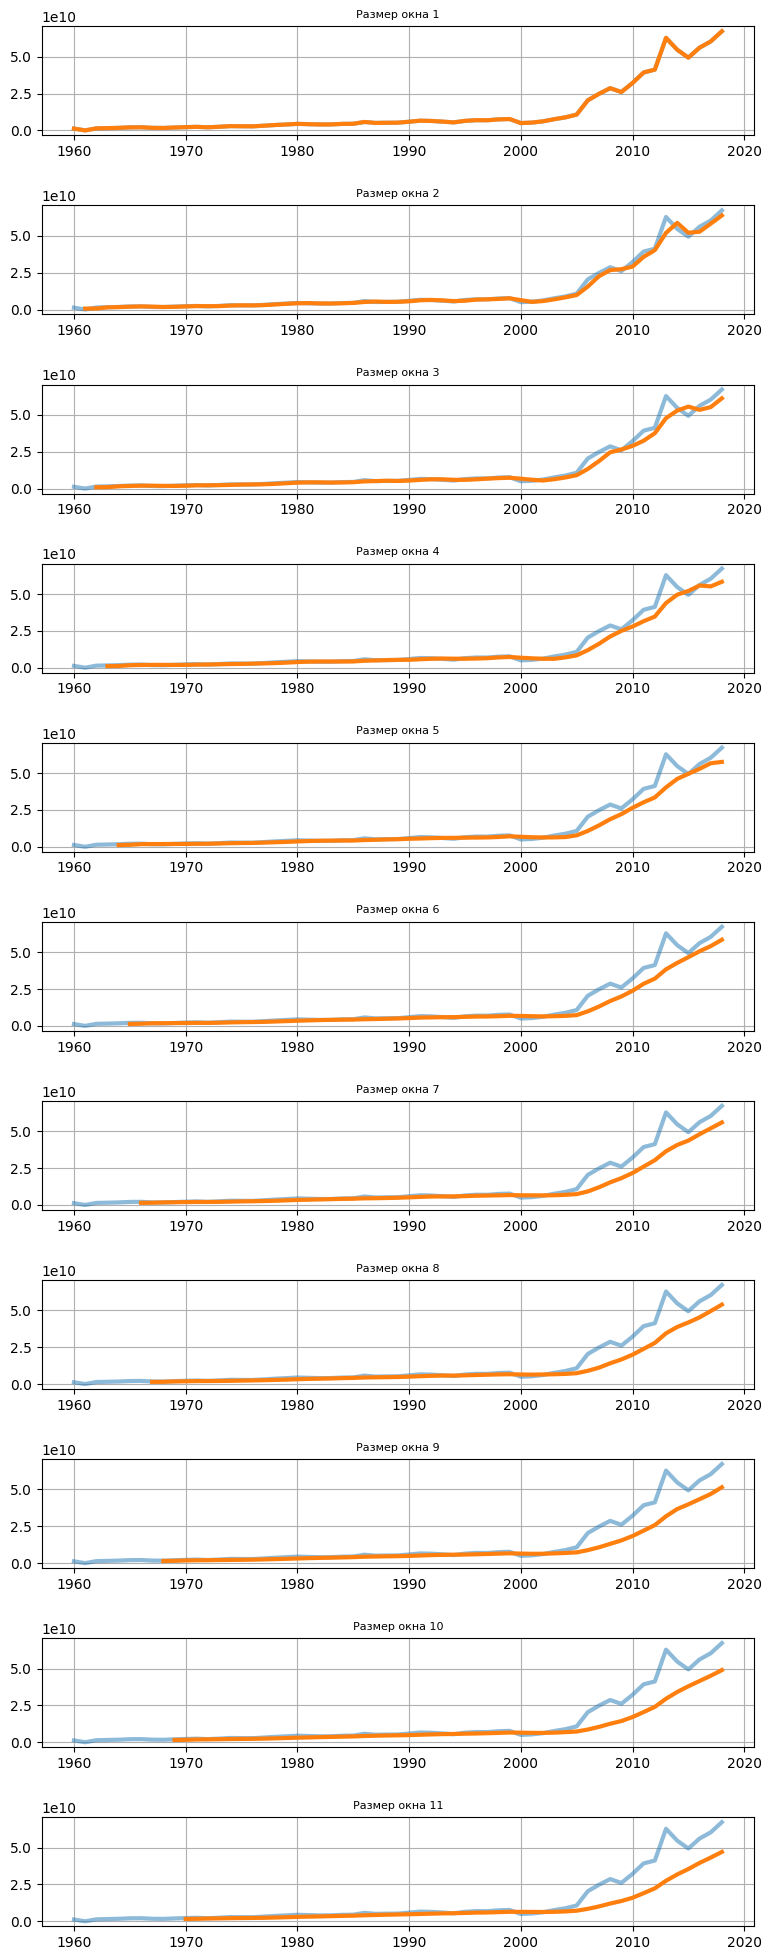

In [202]:
#Подберем оптимальный размер окна с помощью цикла
windows = [i for i in range(1,12)]
fig, axs = plt.subplots(len(windows), 1, figsize=(8,20))

for i, window in enumerate(windows):
    # Строим график
    axs[i].plot(train_df, alpha=0.5)
    axs[i].plot(train_df.rolling(window).mean())
    axs[i].set_title(f'Размер окна {window}',fontsize=8)
    axs[i].grid()

# Упорядочиваем пространство между подграфиками
plt.tight_layout()
plt.show()

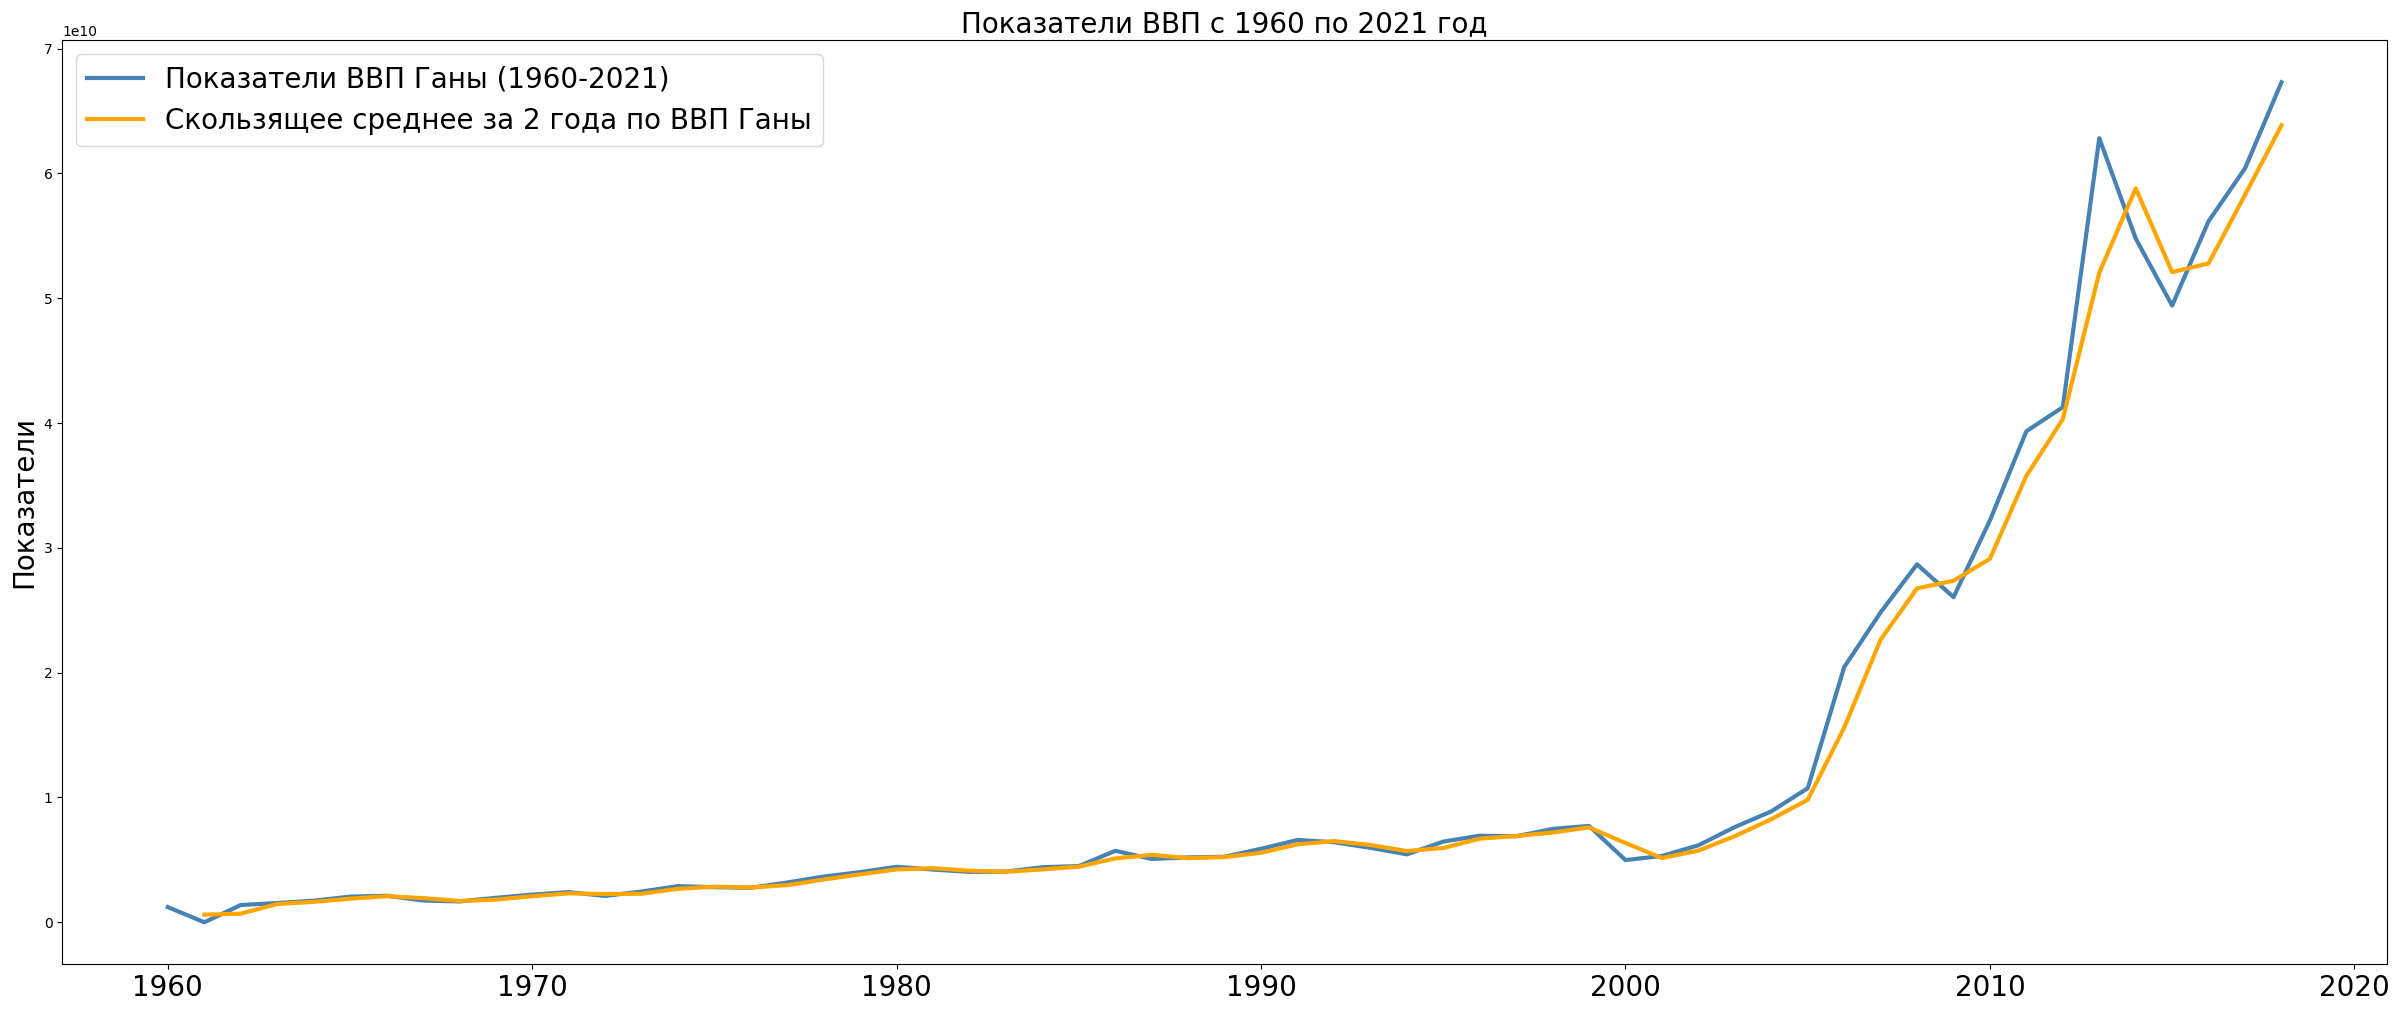

In [203]:
#Визуализируем выбранный размер окна для скользящего среднего 
plt.plot(train_df, label='Показатели ВВП Ганы (1960-2021)',color='steelblue')
plt.plot(train_df.rolling(2).mean(),label= 'Скользящее среднее за 2 года по ВВП Ганы',color='orange')
plt.legend(title = '', loc = 'upper left', fontsize = 20)
plt.ylabel('Показатели', fontsize = 20)
plt.title('Показатели ВВП с 1960 по 2021 год', fontsize = 20)
plt.xticks(fontsize=20)
 
# выведем обе кривые на одном графике
plt.show()

На мой взгляд, есть при размере окна -  2, потеря информации минимально, и в то же время имеется ее сглаживаине. Есть и прослеживающийся период и изменение амплитуды с течением времени.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. Параметры p и q выберите по коррелограммам ACF и PACF. Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

- нулевая гипотеза предполагает, что временной ряд нестационарный;
- альтернативная гипотеза говорит об стационарности.

In [204]:
#Проведем тест Дики-Фуллера с помощью функции
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Будем проводить дифференцирование, пока значение значение статистического теста Дики-Фуллера не станет меньше уровня значимости 5%.

In [205]:
#Найдем количество дифференцирований, при котором котором статистика окажется ниже уровня значимости 5%
i = 1
train = train_df 
new_train = None 
while True:
    test = adfuller(train)
    new_train = train.diff(i).dropna()
    test = adfuller(new_train)
    if test[0] < test[4]['5%']:
        break 
    i+=1

In [206]:
print(f'Для достижения стационарности необходимо {i} дифференцирования')

Для достижения стационарности необходимо 2 дифференцирования


In [207]:
#Переопределим переменную обучающей выборки
train_df = train_df.diff(2).dropna()

Параметр d = 2, поскольку было столько дифференцирований

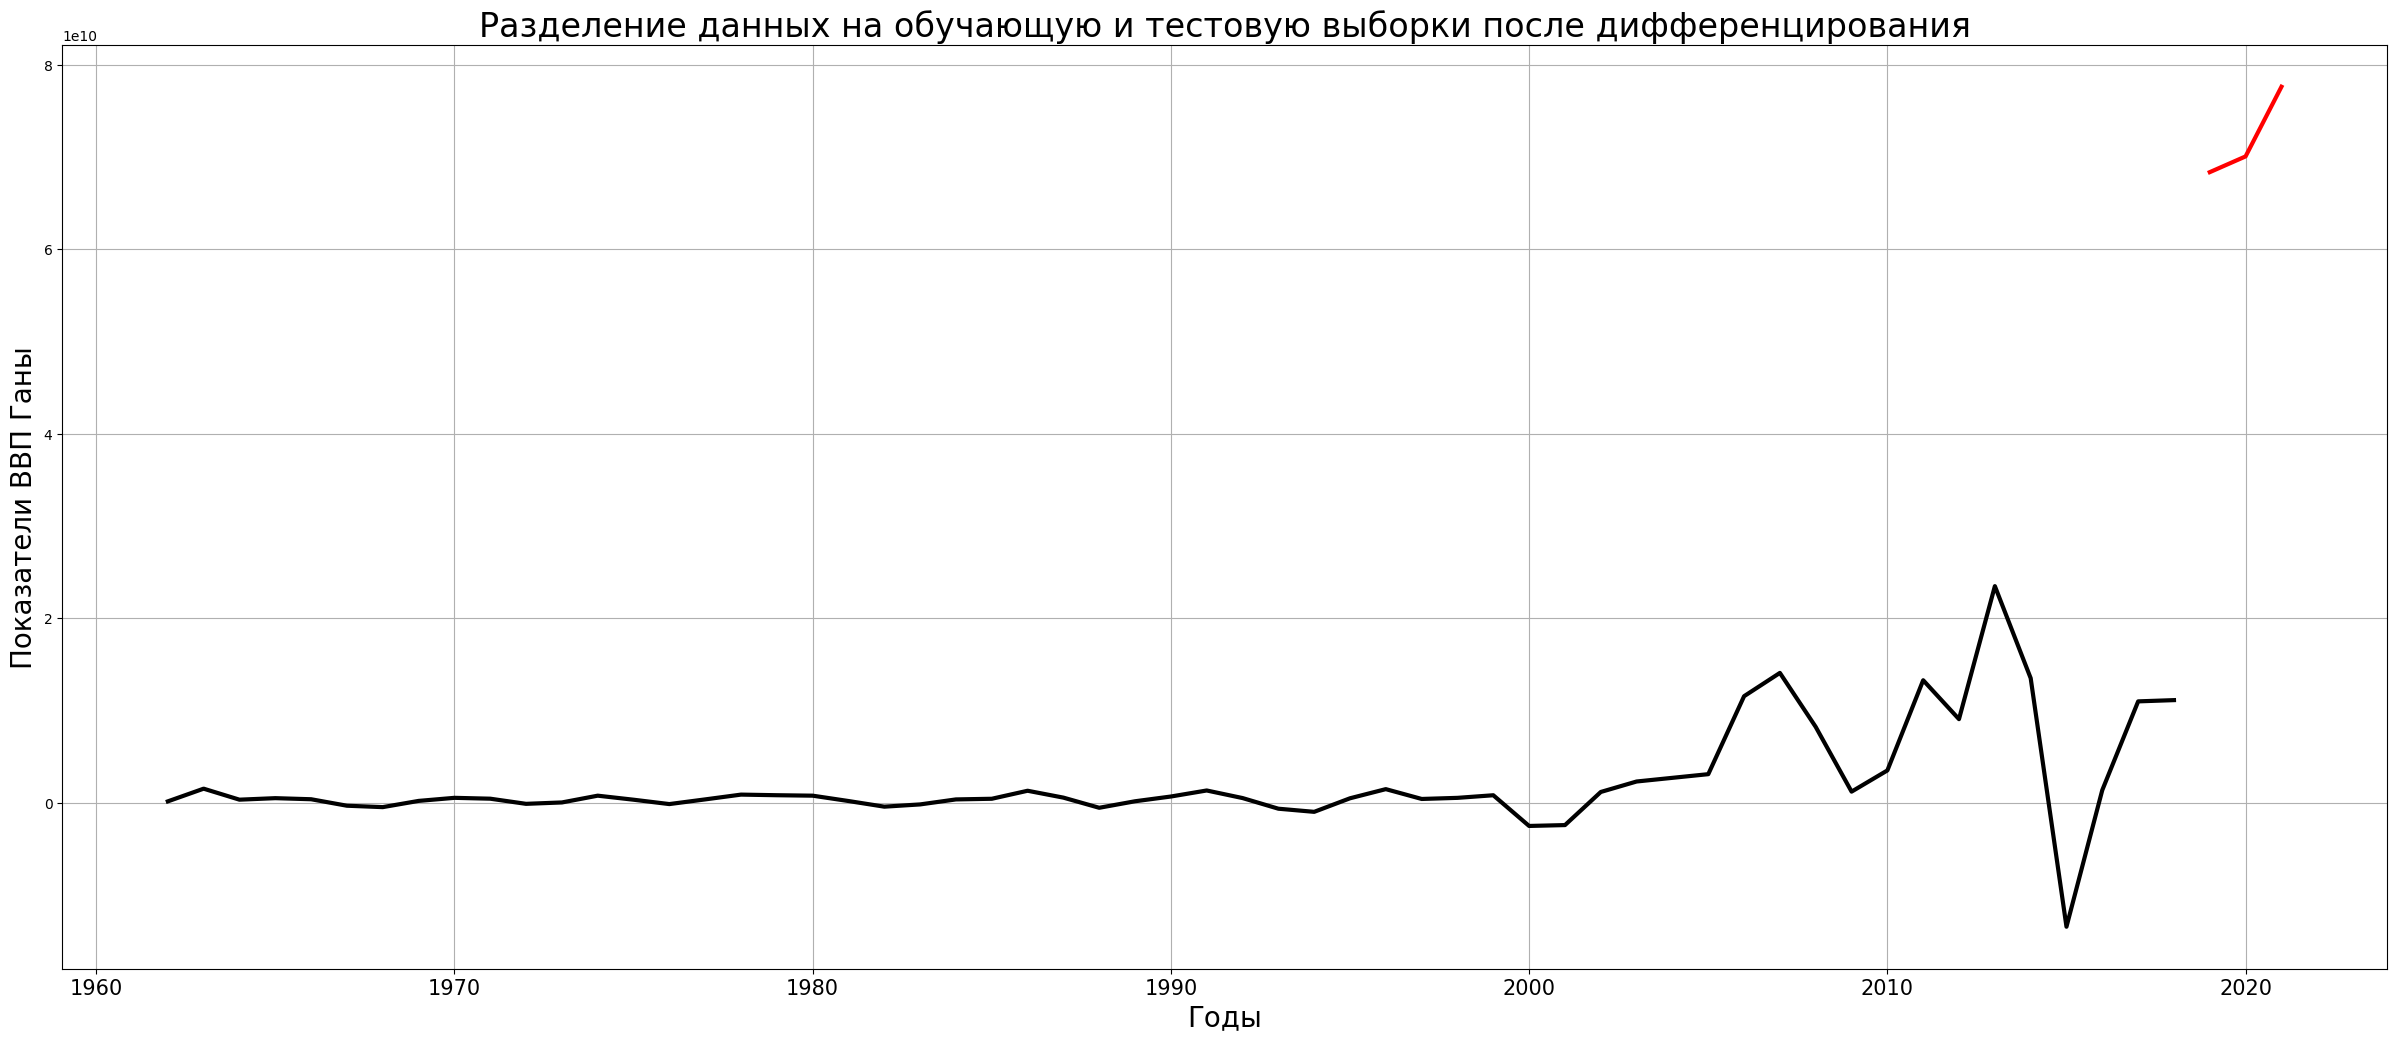

In [208]:
#Визуализируем обучающую и тестову выборки перед обучением моделей
plt.plot(train_df, color = "black")
plt.plot(test_df, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных на обучающую и тестовую выборки после дифференцирования')
plt.ylabel('Показатели ВВП Ганы')
plt.xlabel('Годы')
plt.xticks(fontsize=15)
 
# добавим сетку
plt.grid()
 
plt.show()

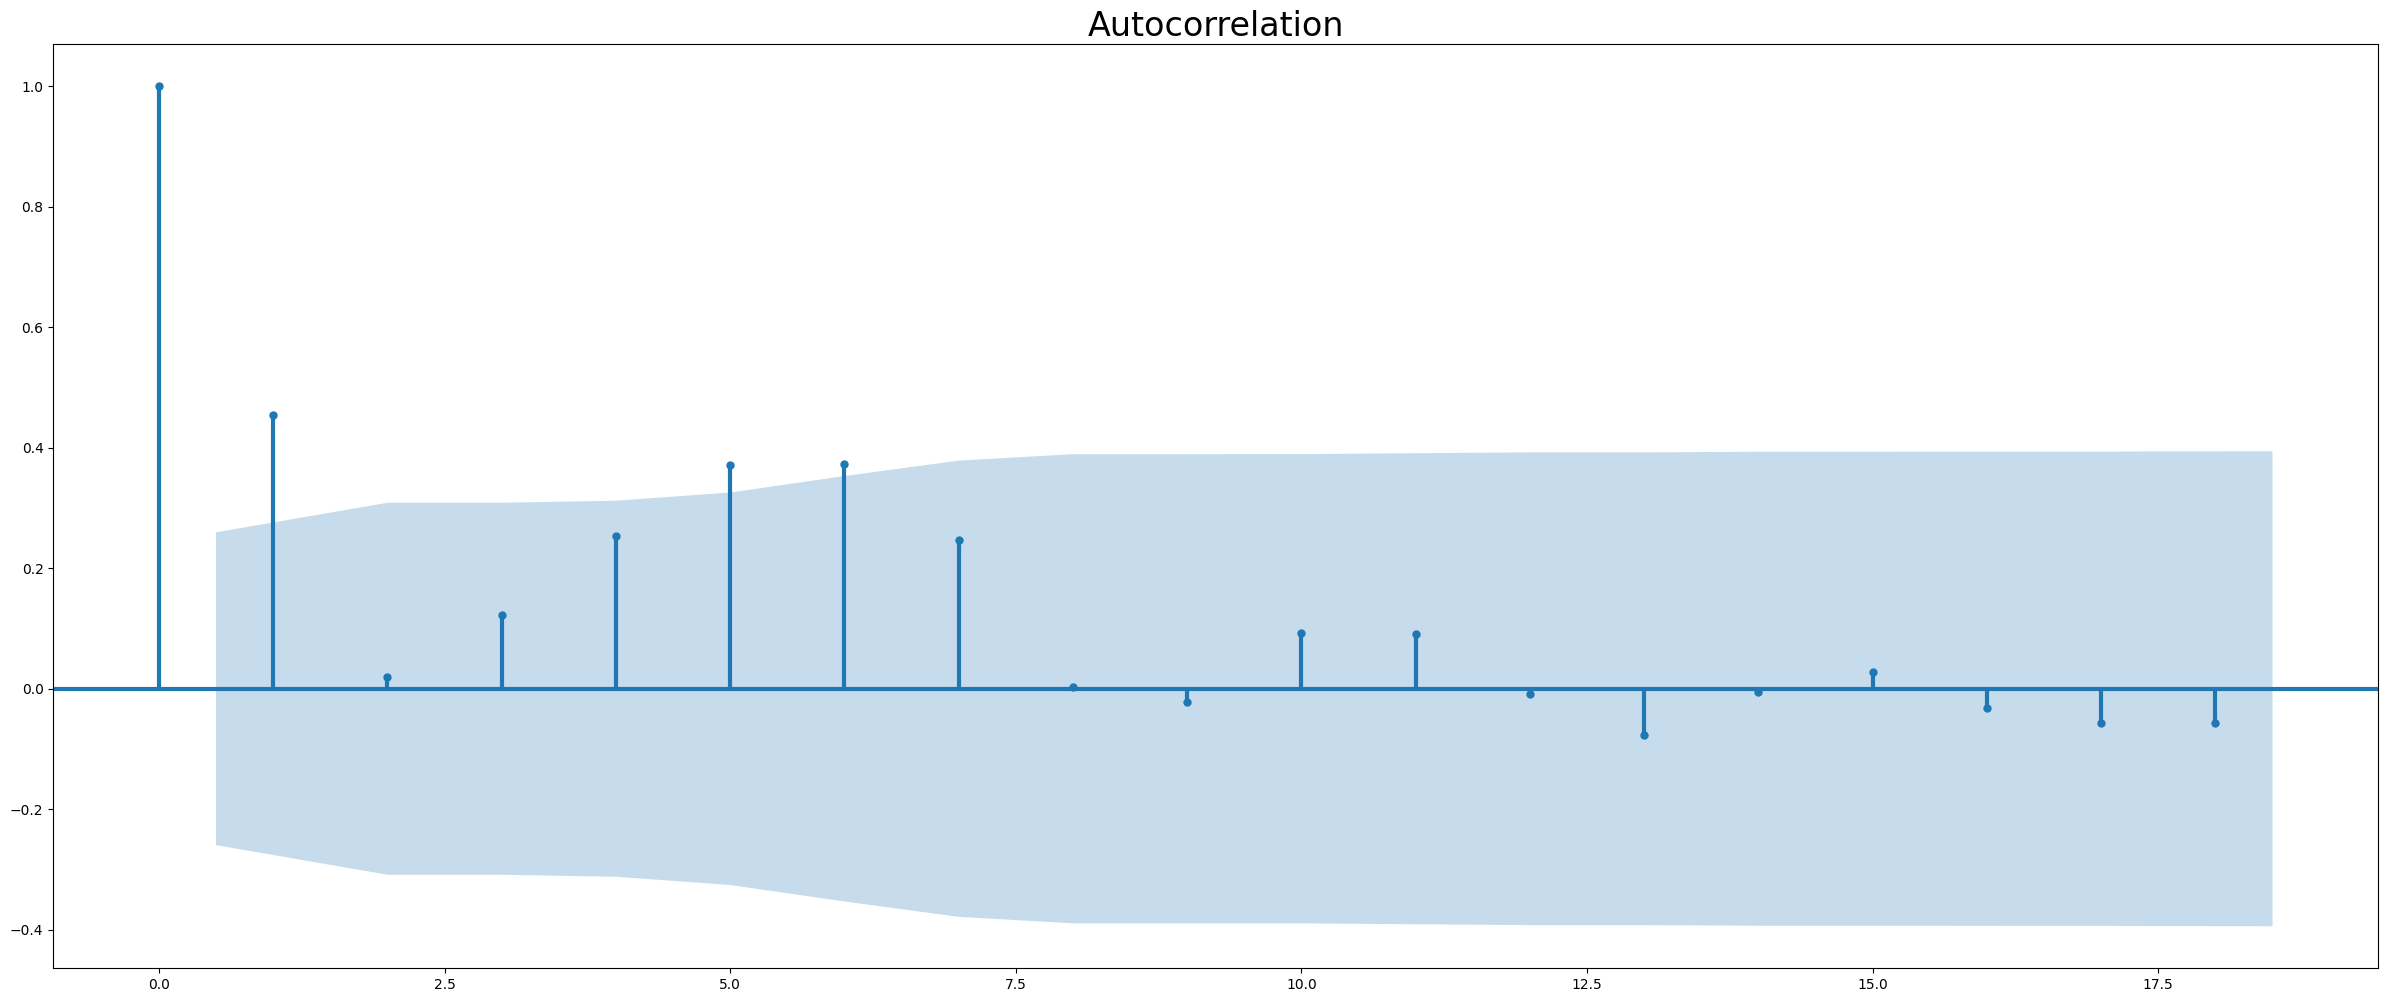

In [209]:
#С помощью корролелограммы найдем параметр q
plot_acf(train_df)
plt.axis('tight')
plt.show()

По графику видно, что максимальное значение на коррелограмме находится в k=1, что может говорить о положительном тренде. Поскольку ряд стационарен, сезонность не видна. В целом корреляция выражена слабо,q=1.

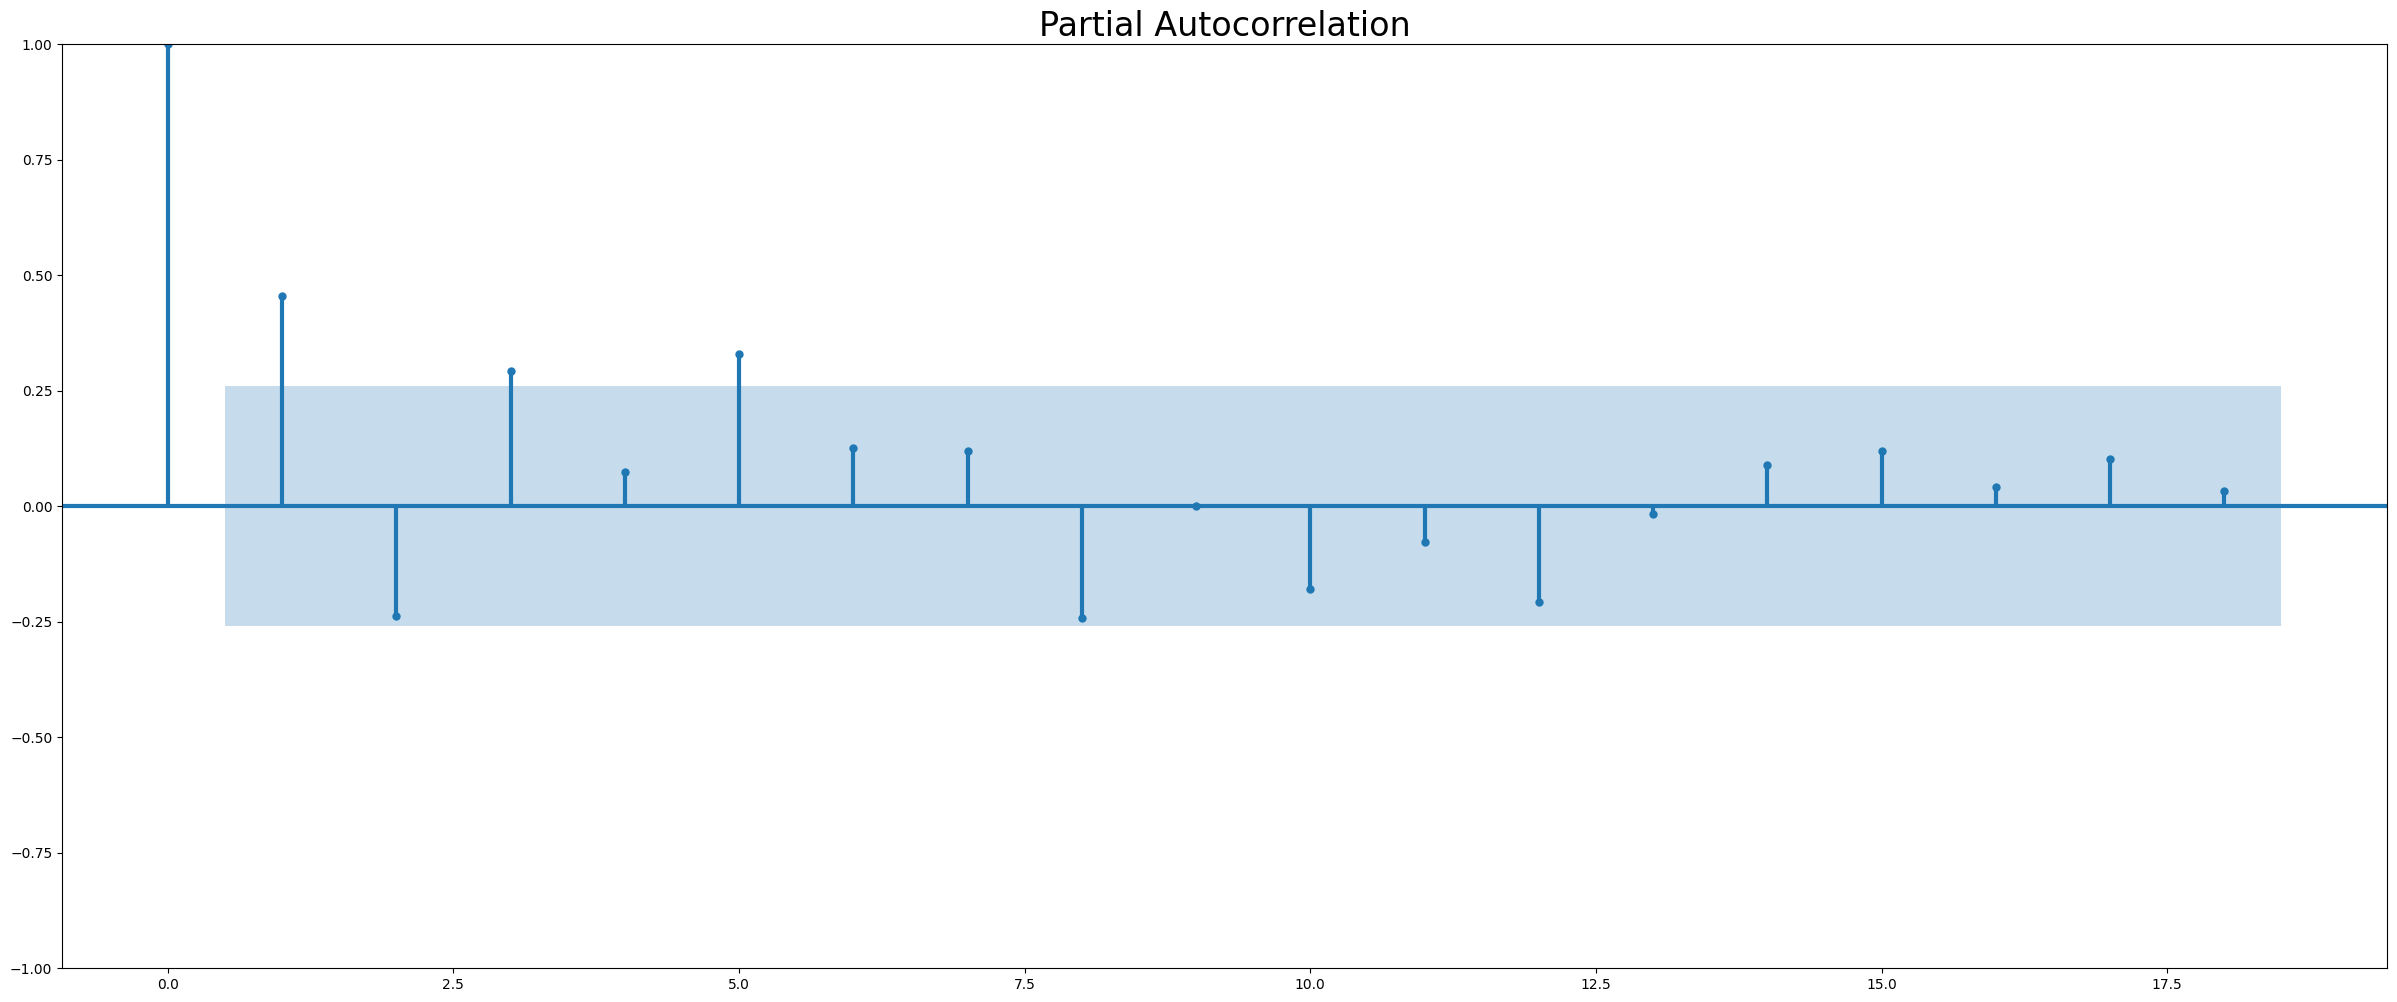

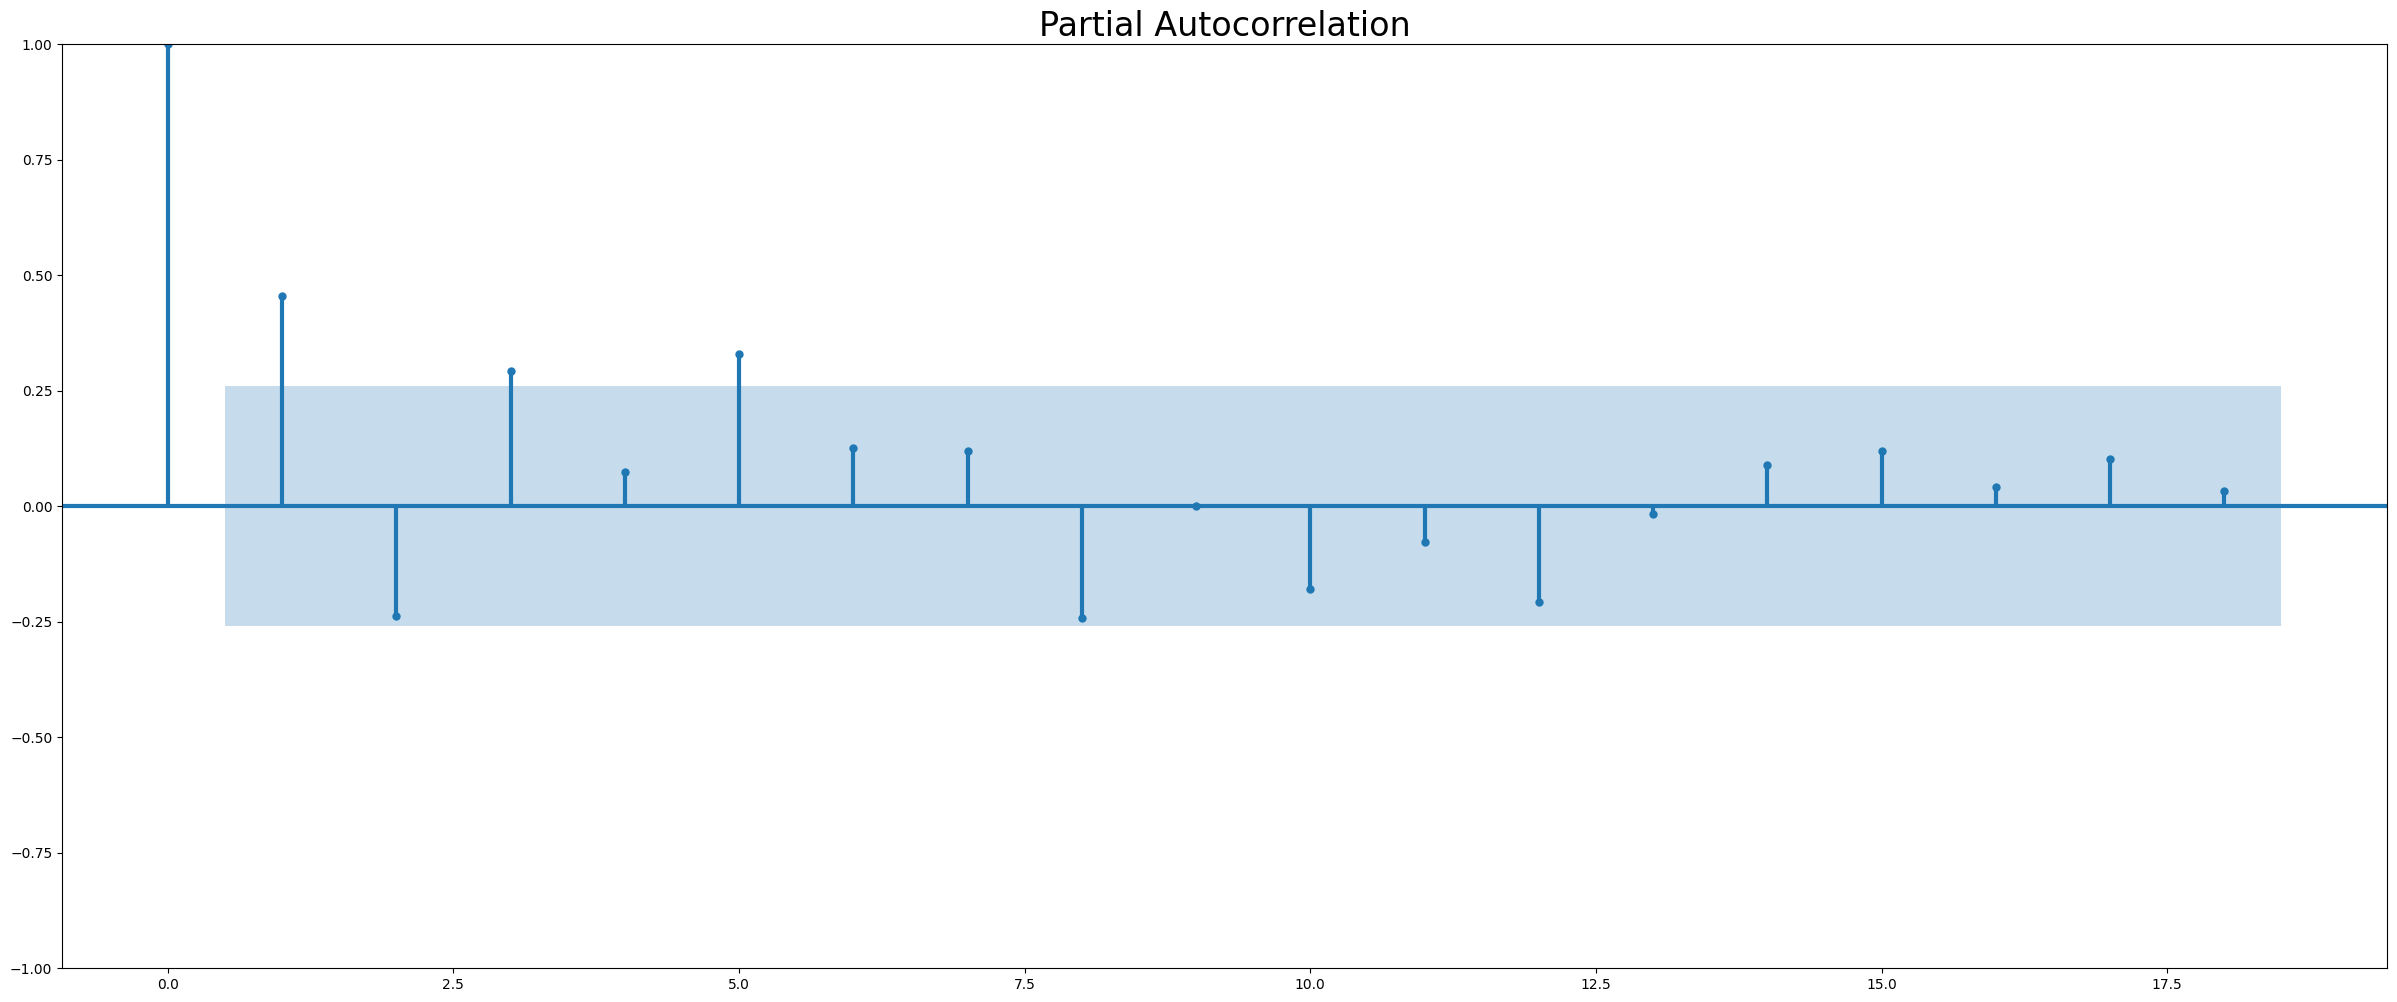

In [210]:
# Построим график частичной автокорреляции, чтобы найти параметр p
plot_pacf(train_df)

Частичная автокорреляция показывает (PACF) также показывает слабовыраженную корреляцию, кроме первого лага, практически все значения в районе 0. Параметр p = 1.Таким образом параметрами для моделей ARMA/ARIMA будут (2,1,1)

Поскольку отсутствует сезонность (SARIMA не подходит), и имеется некий тренд (ARMA не подойдет), здесь подойдет для обучения модель ARIMA

In [211]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(),order=(2,1,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1322.356
Date:                Mon, 03 Feb 2025   AIC                           2652.712
Time:                        16:35:22   BIC                           2660.814
Sample:                    01-01-1962   HQIC                          2655.853
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3024      0.185      1.632      0.103      -0.061       0.666
ar.L2         -0.4544      0.144     -3.163      0.002      -0.736      -0.173
ma.L1         -0.7380      0.158     -4.681      0.000      -1.047      -0.429
sigma2       2.29e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               349.04
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             236.73   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.24e+55. Standard errors may be unstable.
"""

Проведу также обучение модели SARIMAX, только с гиперпараметрами (order), что будет эквивалентно ARIMA

In [212]:
ar_model = SARIMAX(train_df["GDP (current US$)"].dropna(), order=(2, 1, 1))
ar_model_fit = ar_model.fit()
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1322.356
Date:                Mon, 03 Feb 2025   AIC                           2652.712
Time:                        16:35:31   BIC                           2660.814
Sample:                    01-01-1962   HQIC                          2655.853
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3024      0.185      1.632      0.103      -0.061       0.666
ar.L2         -0.4544      0.144     -3.163      0.002      -0.736      -0.173
ma.L1         -0.7380      0.158     -4.681      0.000      -1.047      -0.429
sigma2       2.29e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               349.04
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             236.73   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.24e+55. Standard errors may be unstable.
"""

In [213]:
pred = ar_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

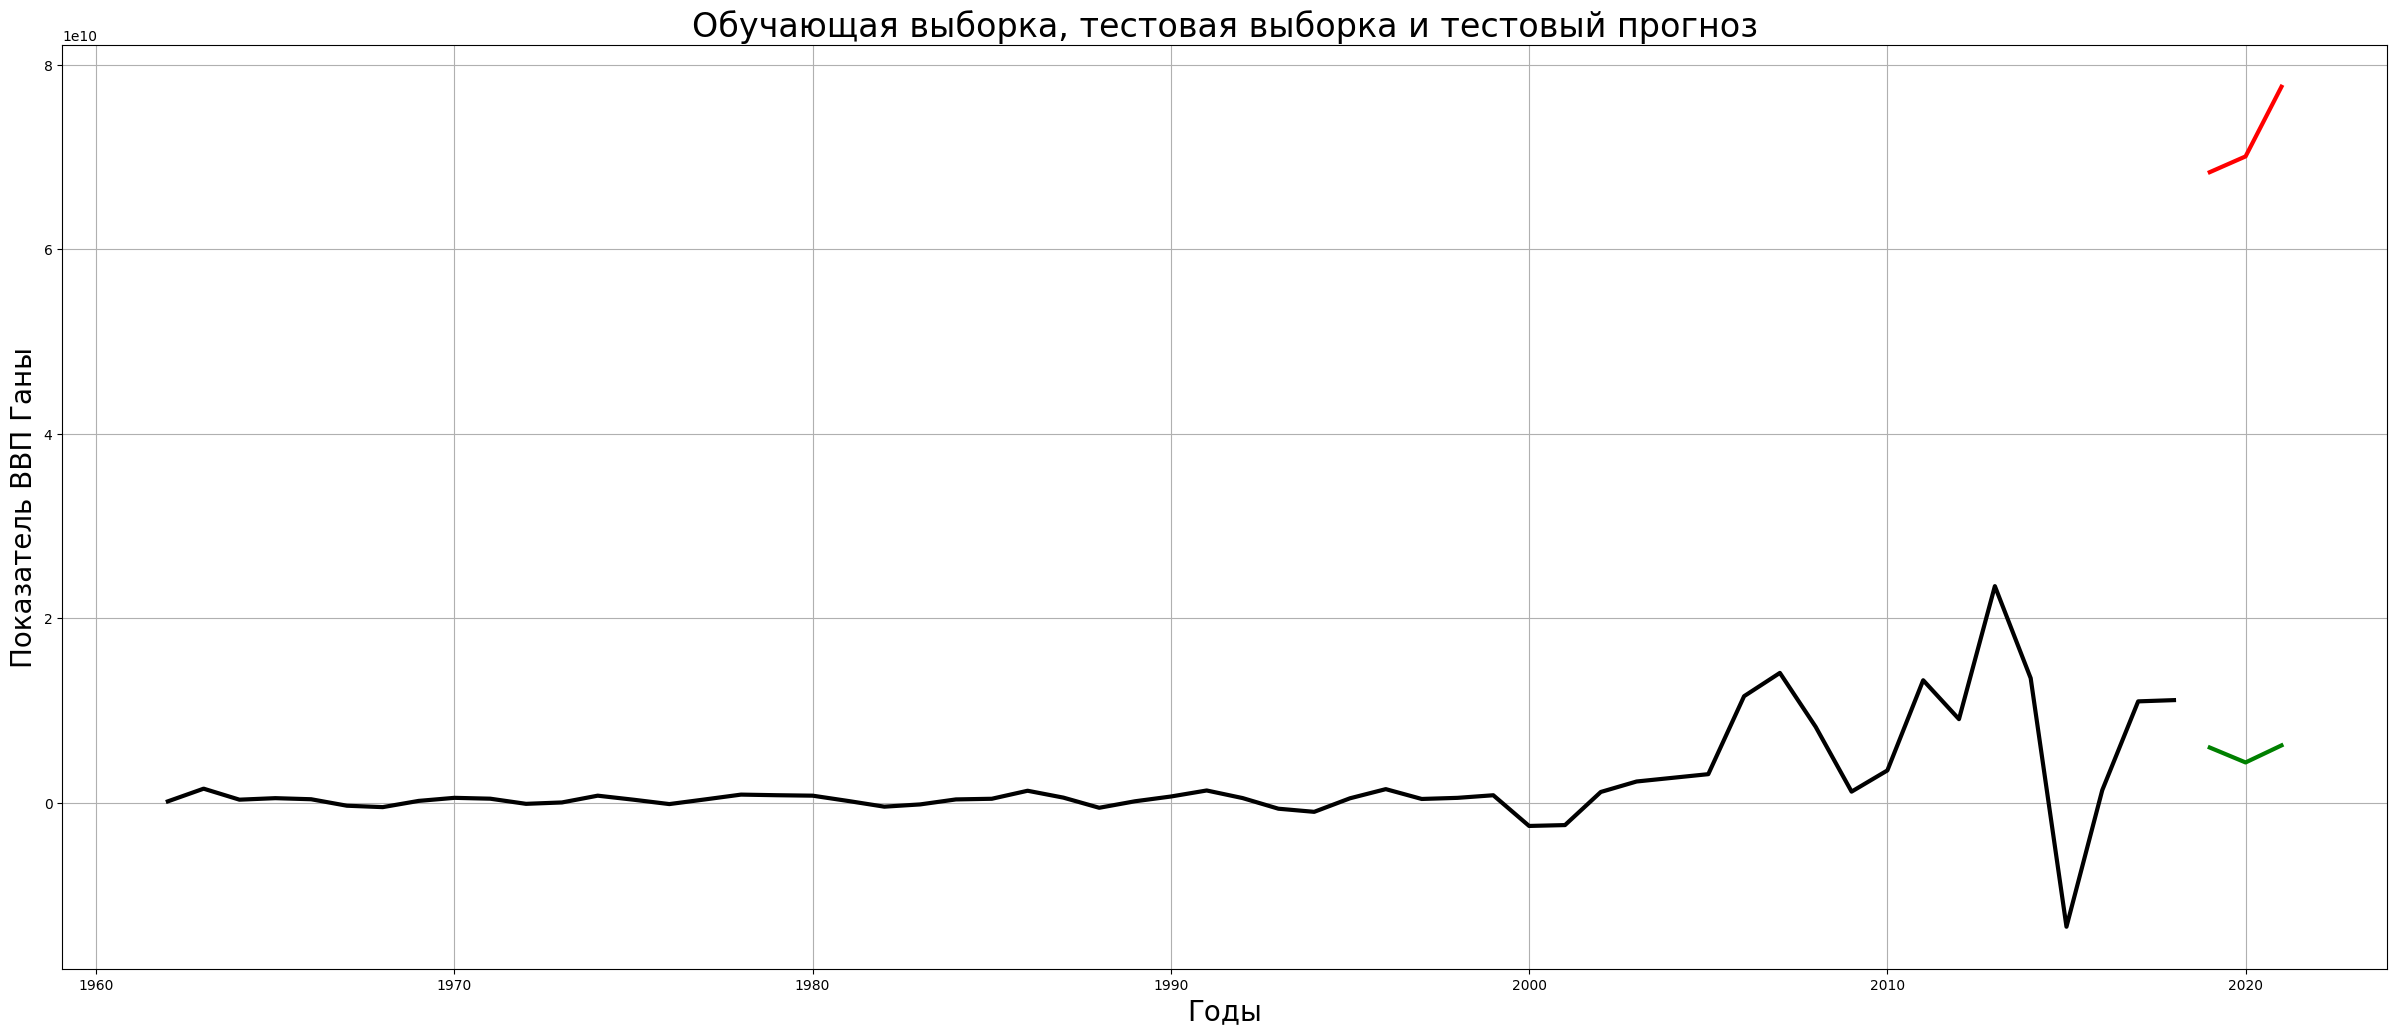

In [214]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train_df, color = "black")
plt.plot(test_df, color = "red")
plt.plot(pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Показатель ВВП Ганы')
plt.xlabel('Годы')
 
# добавим сетку
plt.grid()
 
plt.show()

В обоих случаях показатель AIC 2652.712,однако имеются какие-то проблемы с дисперсией (в строке sigma2).Судя по графику модель не смогла справиться с предсказанием тестовой выборки. Дополнительно убедиться в этом с помощью метрики MAPE:

In [215]:
print('Ошибка MAPE составляет {:.2f} %'.format((mean_absolute_percentage_error(test_df,pred))*100))

Ошибка MAPE составляет 92.31 %


Для улучшения показателя предсказания, можно провести подбор гиперпараметров модели

In [216]:
smodel = pm.auto_arima(
    train,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=15,
    test="adf",
    error_action="ignore",
    trace=True,
)



smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[15]             : AIC=2033.855, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=2035.421, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[15]             : AIC=2036.576, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[15]             : AIC=2032.648, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[15]             : AIC=2033.106, Time=0.16 sec
 ARIMA(1,1,1)(1,1,1)[15]             : AIC=2038.927, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[15]             : AIC=2035.197, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=2035.015, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[15]             : AIC=2032.888, Time=0.13 sec
 ARIMA(1,1,2)(0,1,0)[15]             : AIC=2033.407, Time=0.14 sec
 ARIMA(0,1,2)(0,1,0)[15]             : AIC=2037.289, Time=0.03 sec
 ARIMA(2,1,0)(0,1,0)[15]             : AIC=2036.358, Time=0.02 sec
 ARIMA(2,1,2)(0,1,0)[15]             : AIC=2030.058, Time=0.11 sec
 ARIMA(2,1,2)(1,1,0)[15]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 15)   Log Likelihood               -1010.029
Date:                             Mon, 03 Feb 2025   AIC                           2030.058
Time:                                     16:35:58   BIC                           2038.864
Sample:                                 01-01-1960   HQIC                          2033.306
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3658      0.219      6.239      0.000       0.937       1.795
ar.L2         -0.4683      0.261     -1.791      0.073      -0.981       0.044
ma.L1         -1.6623      0.140    -11.870      0.000      -1.937      -1.388
ma.L2          0.9005      0.148      6.087      0.000       0.611       1.190
sigma2      1.885e+19   4.54e-21   4.15e+39      0.000    1.89e+19    1.89e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                86.59
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):             179.15   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.67e+56. Standard errors may be unstable.
"""

Более менее низкий показатель AIC получается при m =15. Подставим в модель получившиеся оптимальные гиперпараметры

In [217]:
model = SARIMAX(train_df["GDP (current US$)"].dropna(), order=(2,1,2),seasonal_order=(0,1,0,15))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   GDP (current US$)   No. Observations:                   57
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 15)   Log Likelihood                -968.190
Date:                             Mon, 03 Feb 2025   AIC                           1946.379
Time:                                     16:36:05   BIC                           1954.947
Sample:                                 01-01-1962   HQIC                          1949.499
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3214      0.445     -0.722      0.470      -1.194       0.551
ar.L2         -0.1746      0.556     -0.314      0.753      -1.263       0.914
ma.L1          0.1442      0.289      0.499      0.618      -0.422       0.711
ma.L2         -0.7803      0.310     -2.514      0.012      -1.389      -0.172
sigma2      2.628e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               118.46
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              58.33   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.85e+53. Standard errors may be unstable.
"""

Показатель AIC несколько уменьшился

Сделаю предсказание модели

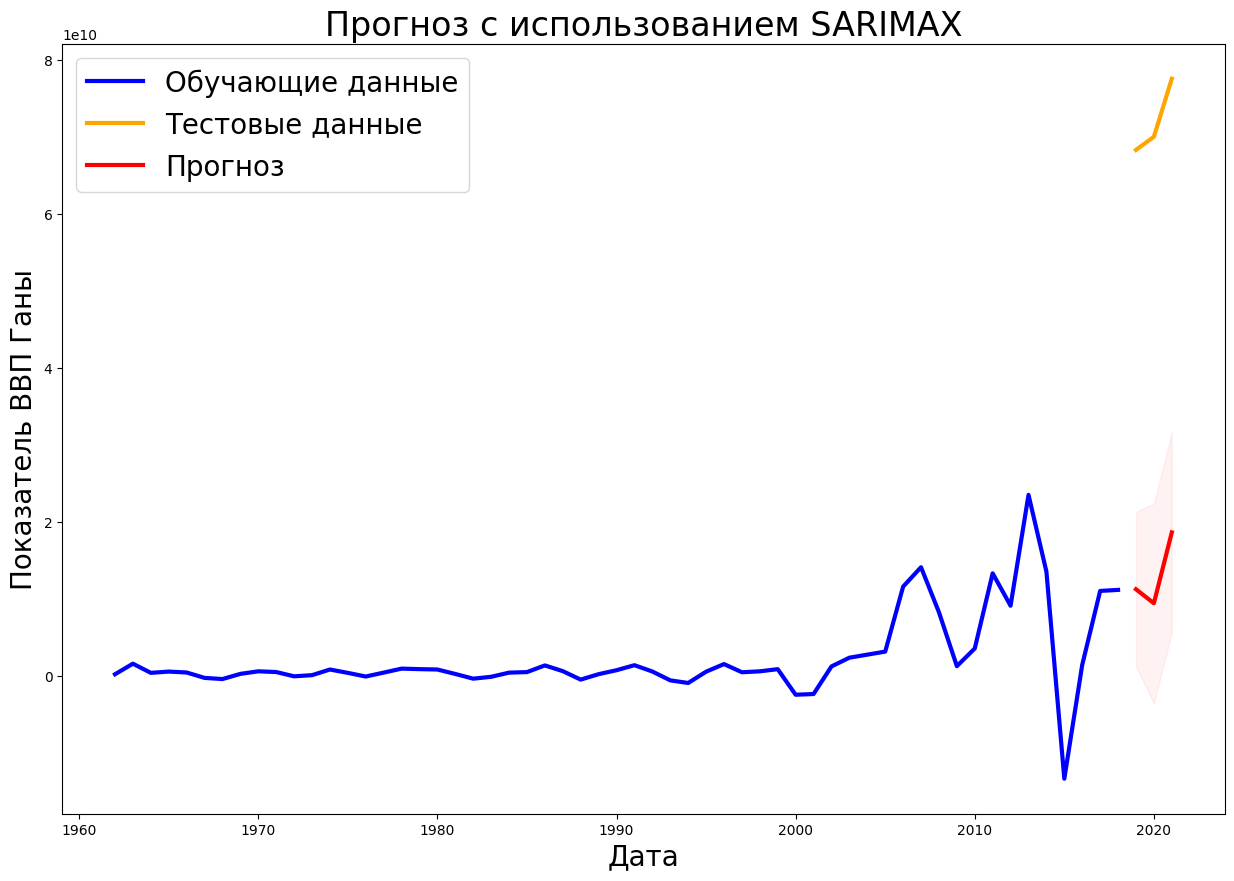

In [218]:
# Прогнозирование
forecast = model_fit.get_forecast(len(test_df.index))  # Получение прогноза
forecast_index = test_df.index
forecast_values = model_fit.predict(test_df.index[0],test_df.index[-1])

# Получение доверительных интервалов
conf_int = forecast.conf_int(alpha=0.05)

# Визуализация
plt.figure(figsize=(15, 10))
plt.plot(train_df, label='Обучающие данные', color='blue')
plt.plot(test_df, label='Тестовые данные', color='orange')
plt.plot(forecast_index, forecast_values, label='Прогноз', color='red')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='red',alpha=0.05)
plt.title('Прогноз с использованием SARIMAX')
plt.xlabel('Дата')
plt.ylabel('Показатель ВВП Ганы')
plt.legend()
plt.show()

In [219]:
print('Ошибка MAPE составляет {:.2f} %'.format((mean_absolute_percentage_error(test_df,forecast_values))*100))

Ошибка MAPE составляет 82.06 %


Вывод: модели ARIMA/SARIMAX (с подбором гиперпараметров) не смогли сделать качественные предсказания модели, получились большие ошибки MAPE

5. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [220]:
df.asfreq('AS').isna().sum()

GDP (current US$)    0
dtype: int64

In [221]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [222]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

6. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [159]:
train_df = df[:'2018-01-01']
test_df = df['2019-01-01':]

Проверим на стационарность обучающую выборку

In [160]:
stat_test(train_df.diff(2).dropna())

adf:  -3.999803440949147
p-value:  0.0014115408436661371
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен


In [161]:
train_df = train_df.diff(2).dropna()

Выборка вновь стационарна, если ее дифференцировать 2 раза

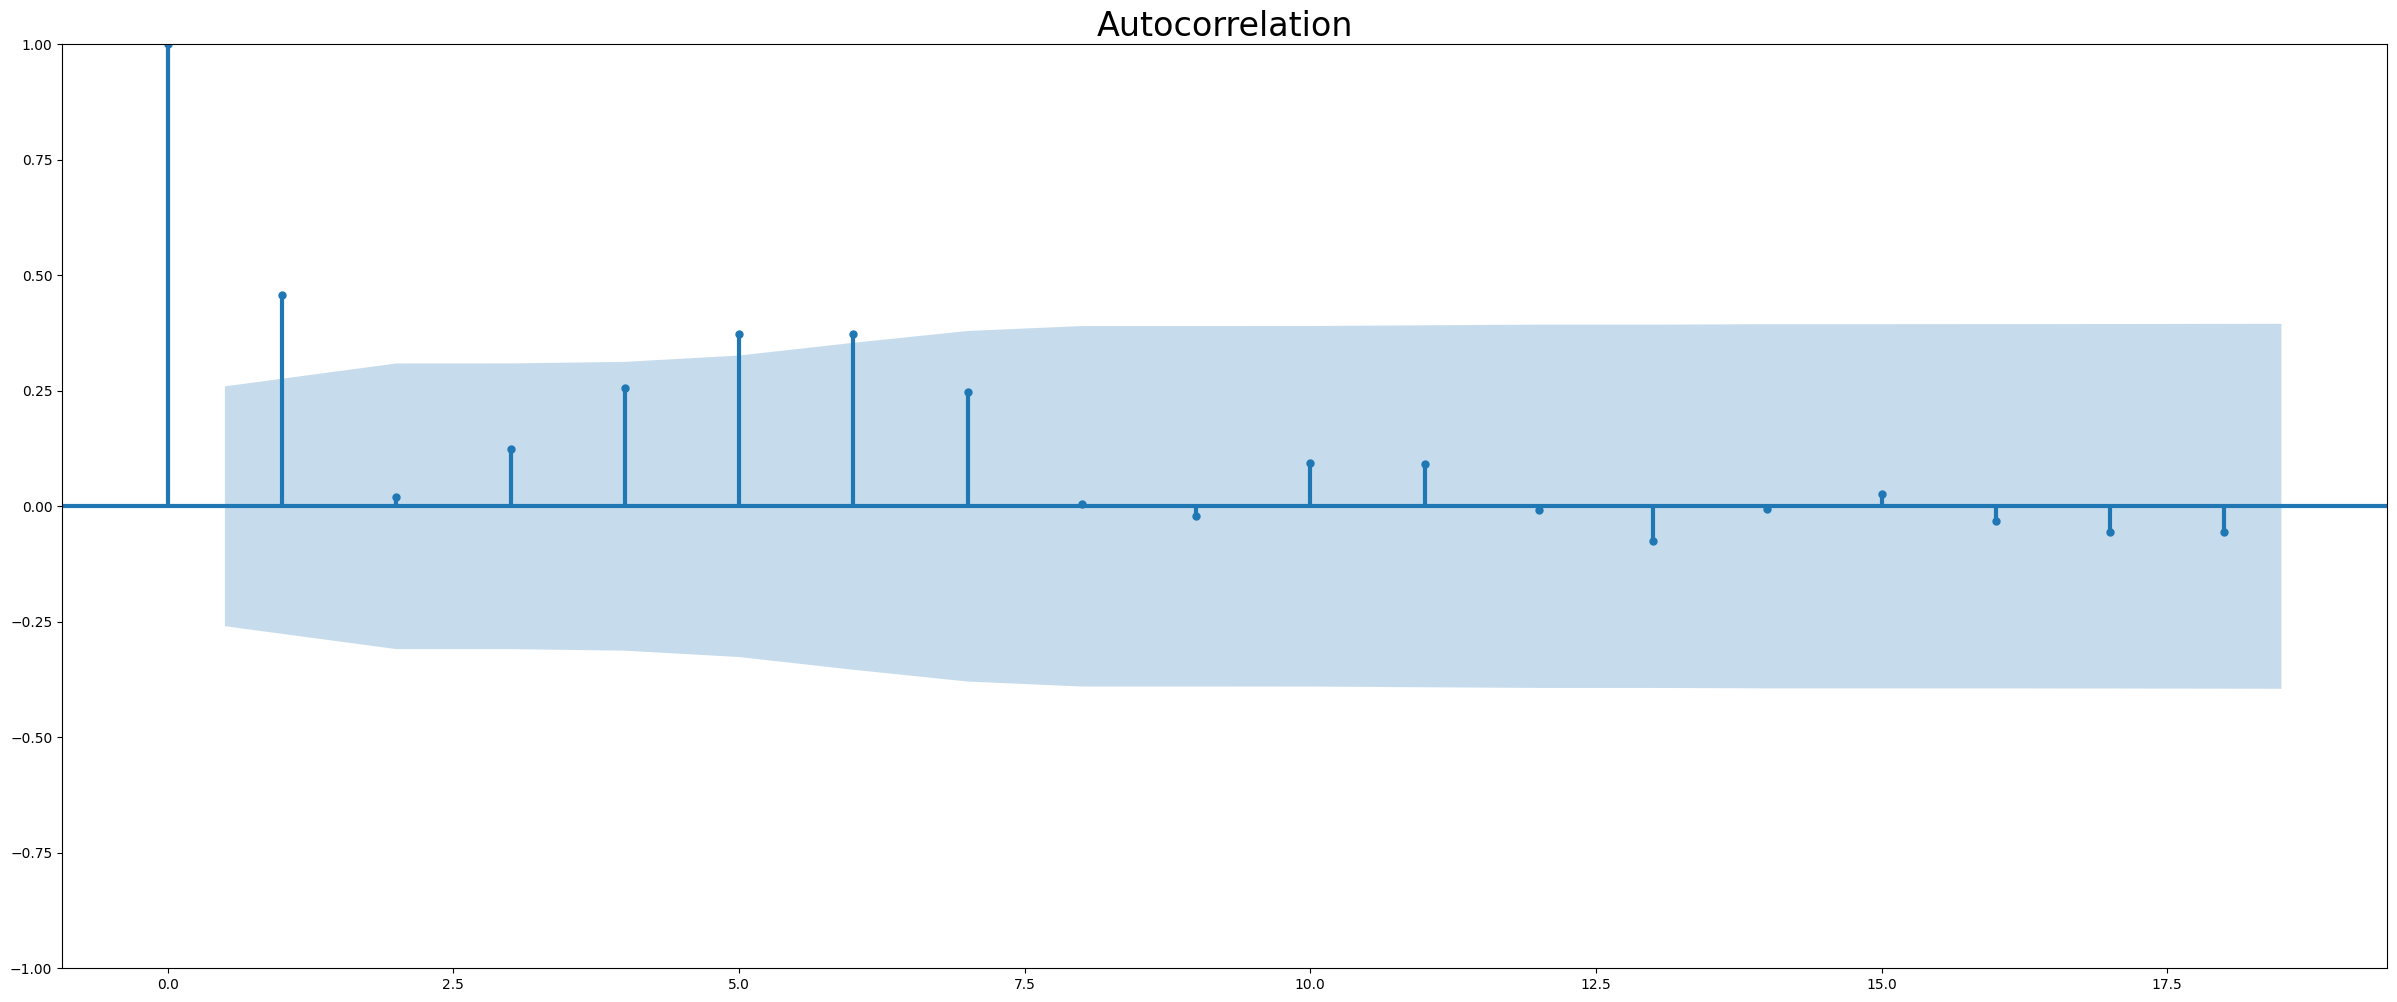

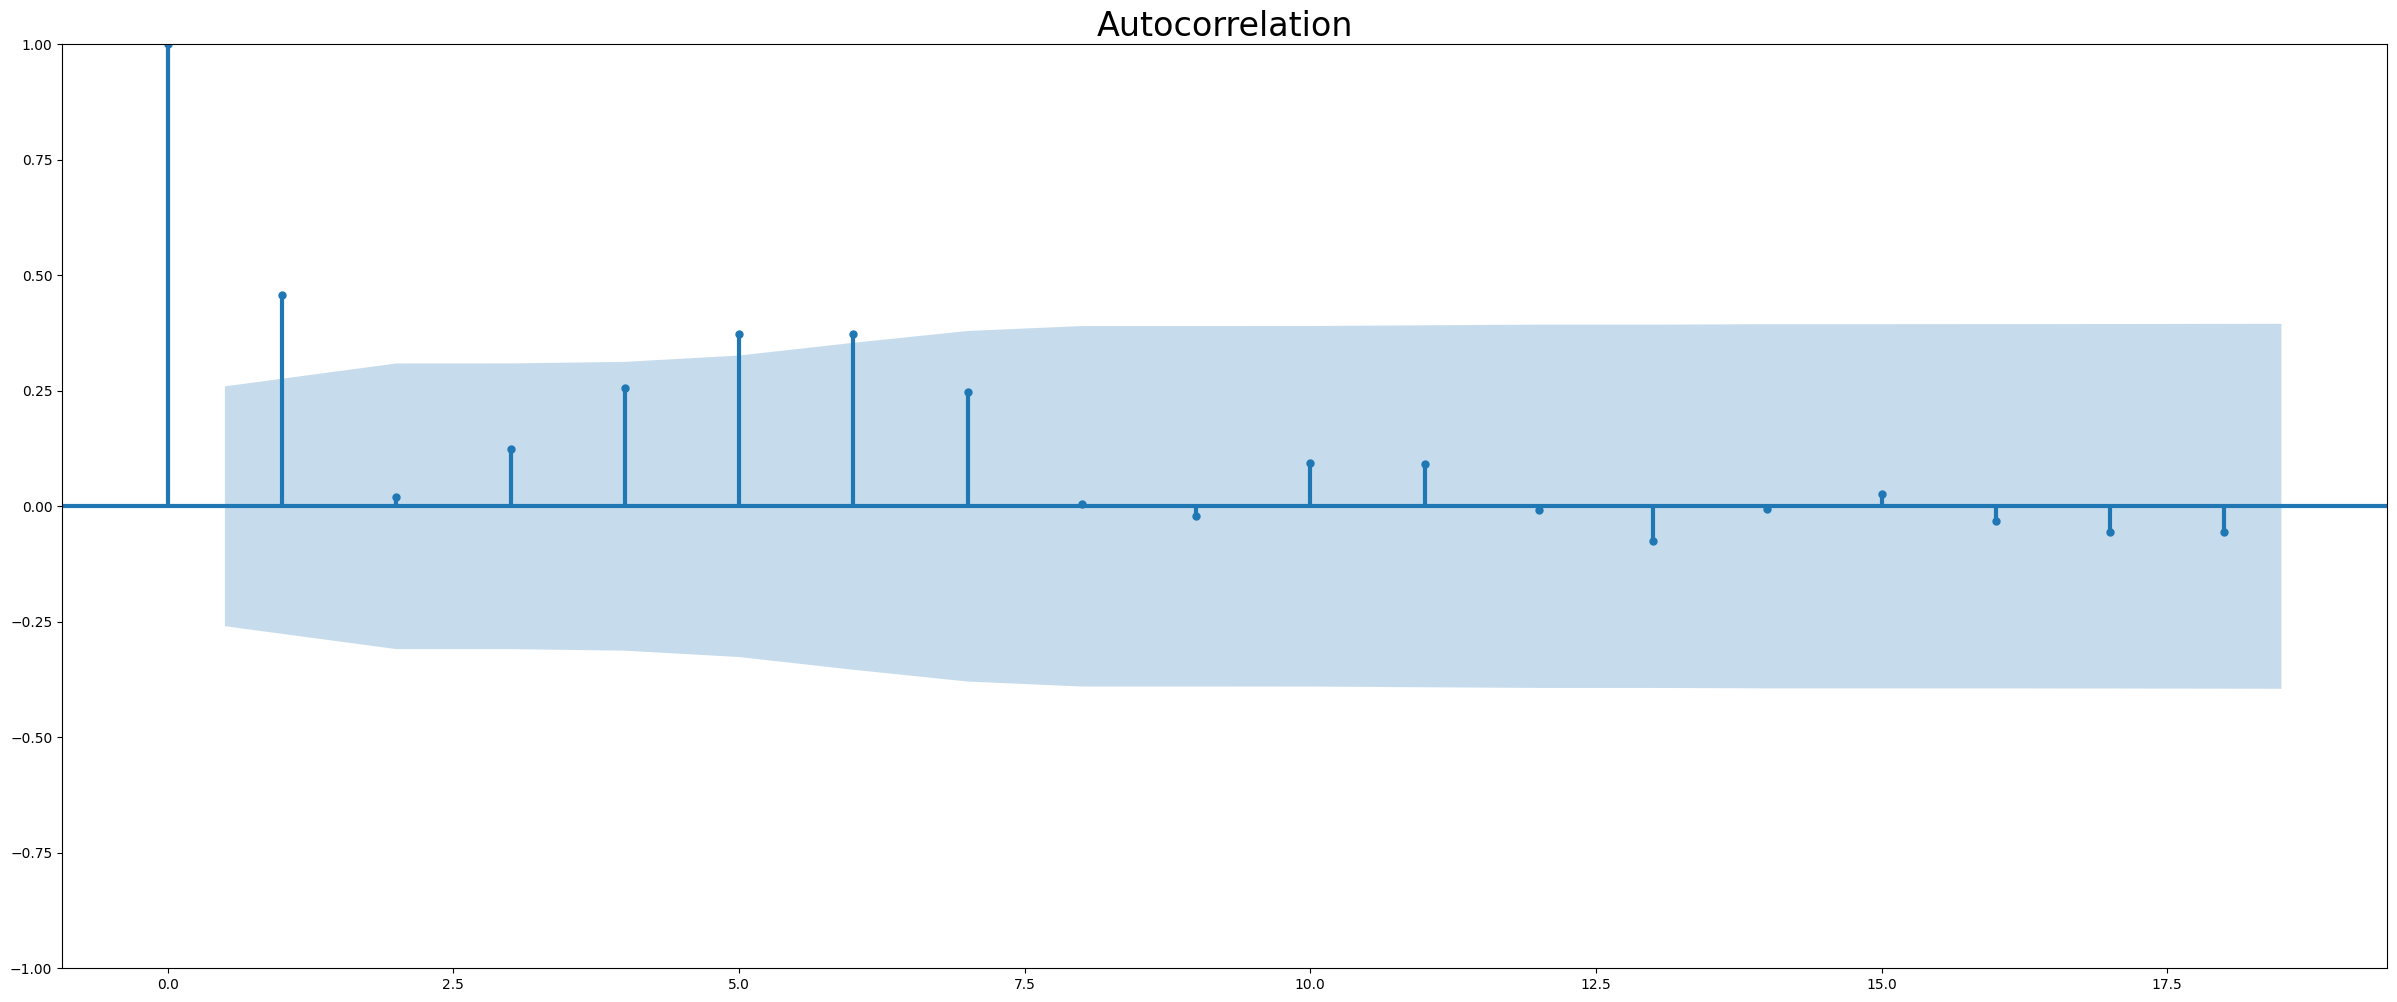

In [162]:
plot_acf(train_df)

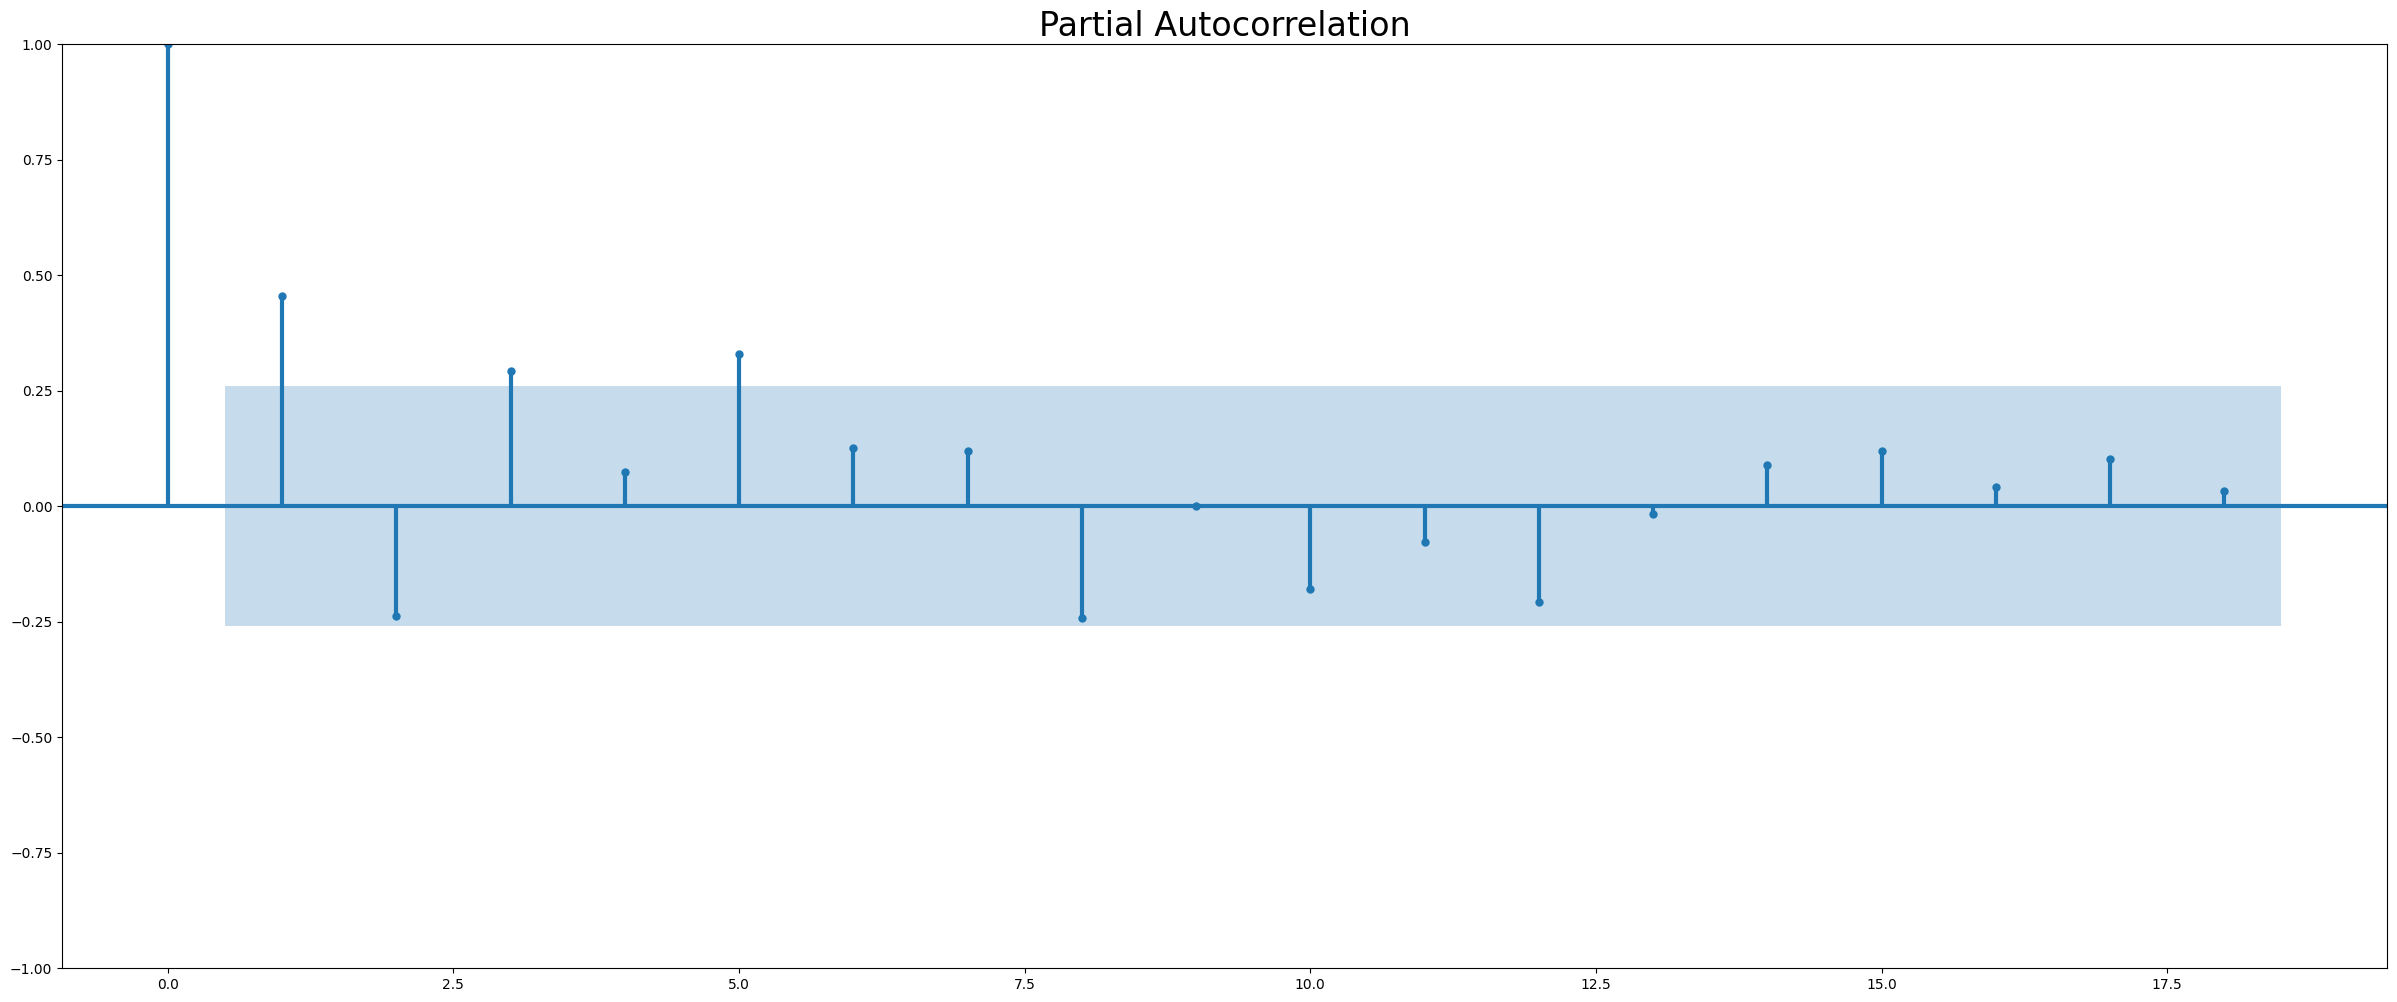

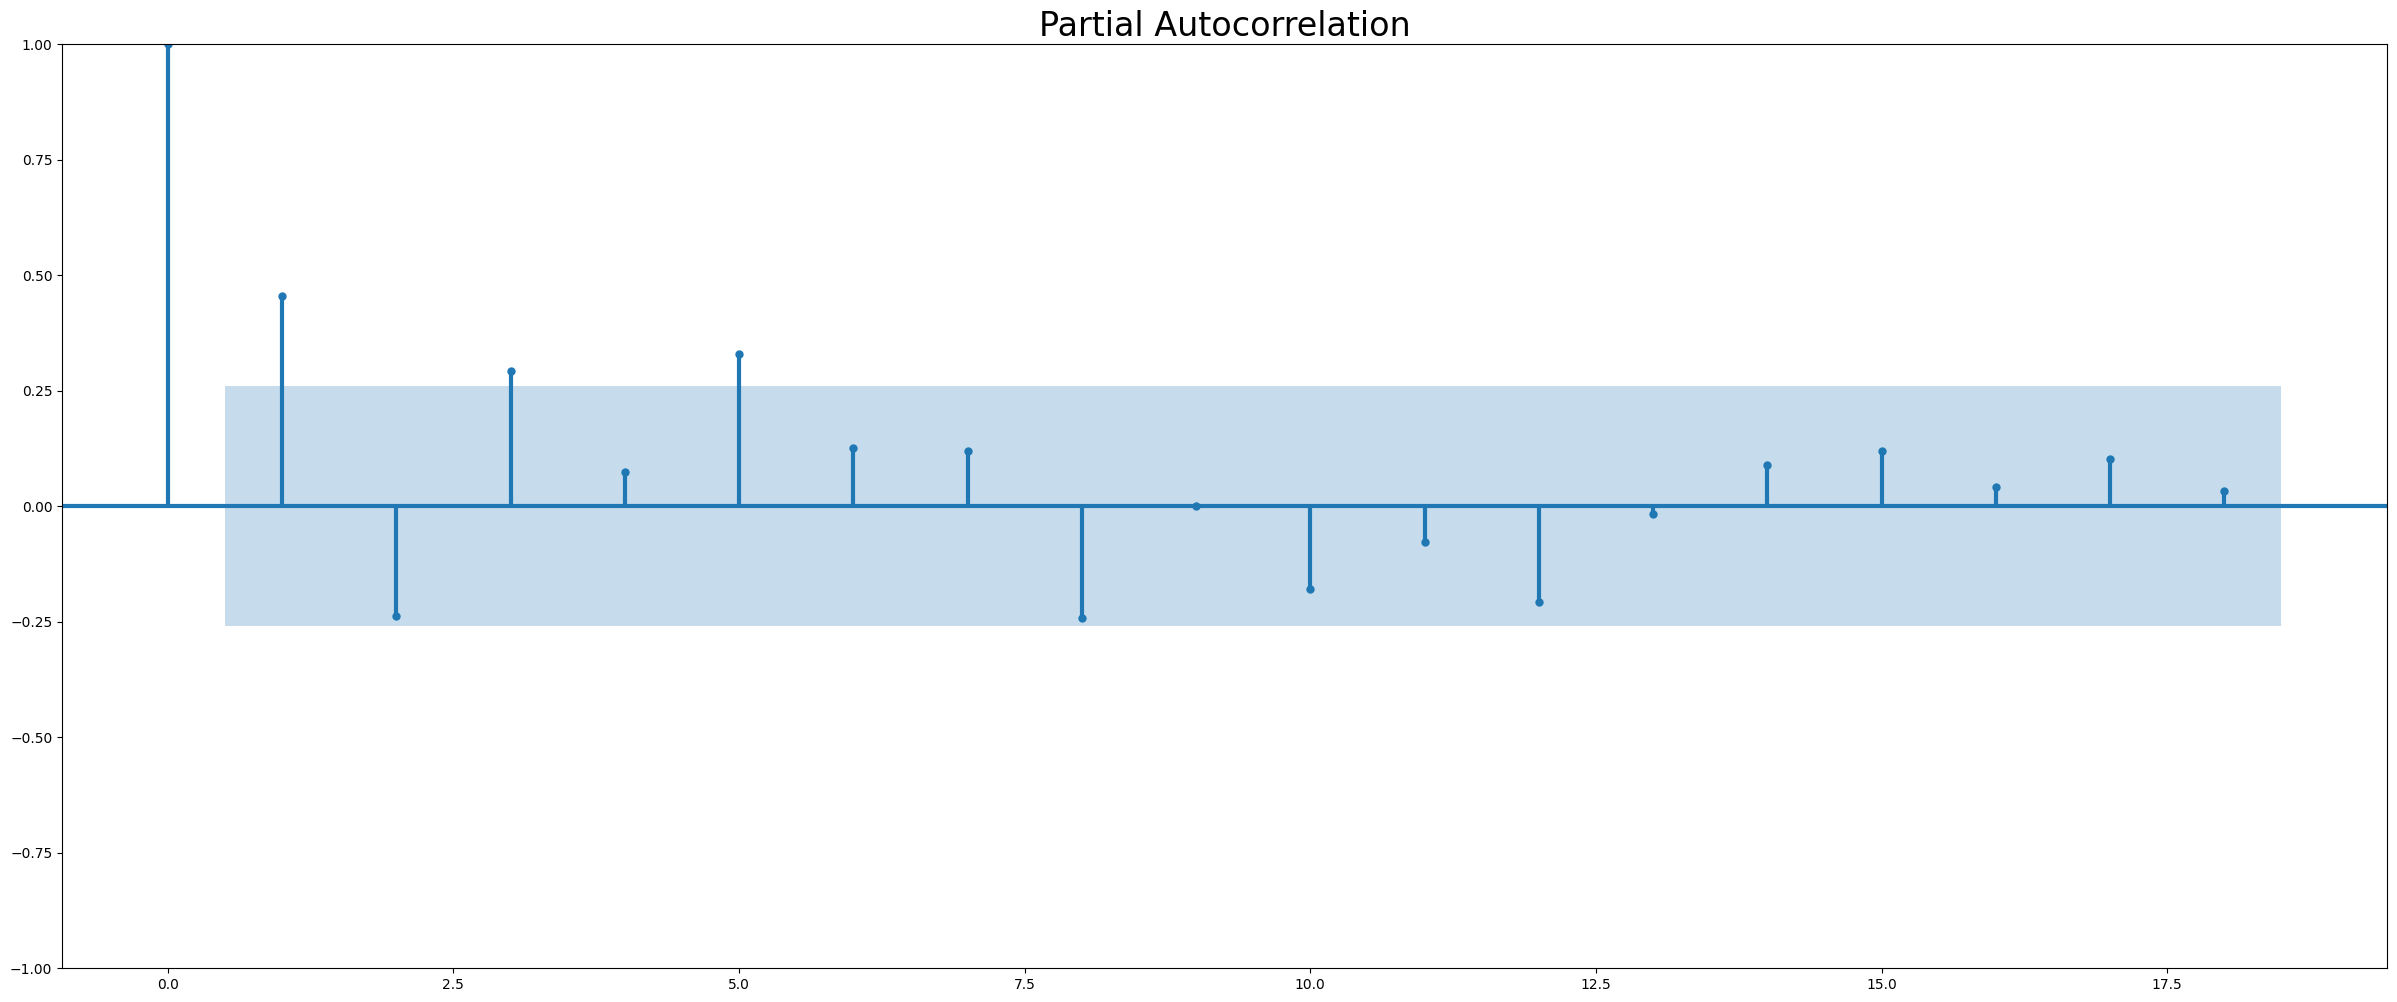

In [223]:
plot_pacf(train_df)

Изменений никаких не произошло, параметры q и p остаются неизменными (1 и 1). 

In [224]:
ar_model = SARIMAX(train_df["GDP (current US$)"].dropna(), order=(2, 1, 1))
ar_model_fit = ar_model.fit()
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1322.356
Date:                Mon, 03 Feb 2025   AIC                           2652.712
Time:                        16:36:57   BIC                           2660.814
Sample:                    01-01-1962   HQIC                          2655.853
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3024      0.185      1.632      0.103      -0.061       0.666
ar.L2         -0.4544      0.144     -3.163      0.002      -0.736      -0.173
ma.L1         -0.7380      0.158     -4.681      0.000      -1.047      -0.429
sigma2       2.29e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               349.04
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             236.73   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.24e+55. Standard errors may be unstable.
"""

In [225]:
print('Ошибка MAPE составляет {:.2f} %'.format((mean_absolute_percentage_error(test_df,pred))*100))

Ошибка MAPE составляет 92.31 %


Значения AIC и MAPE остались теми же, что и до интерполяции.

7. Посчитайте волатильность для вашего временного ряда. Используйте GARCH-модель для предсказания волатильности.


In [226]:
df["vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()


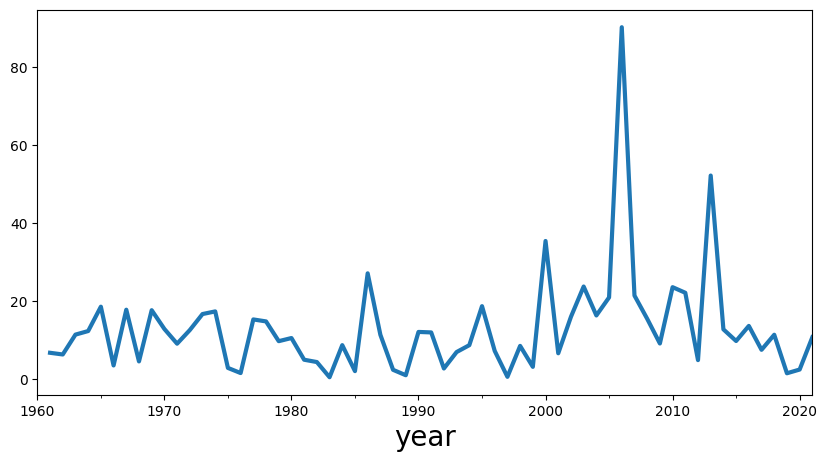

In [237]:
df.vol.plot()
plt.show()

In [227]:
#разделим данные на тренировочную и тестовые выборки
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01 ":]

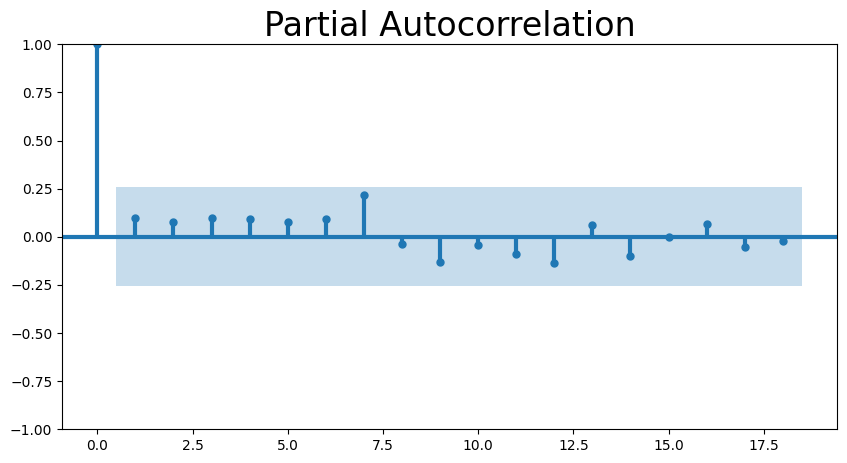

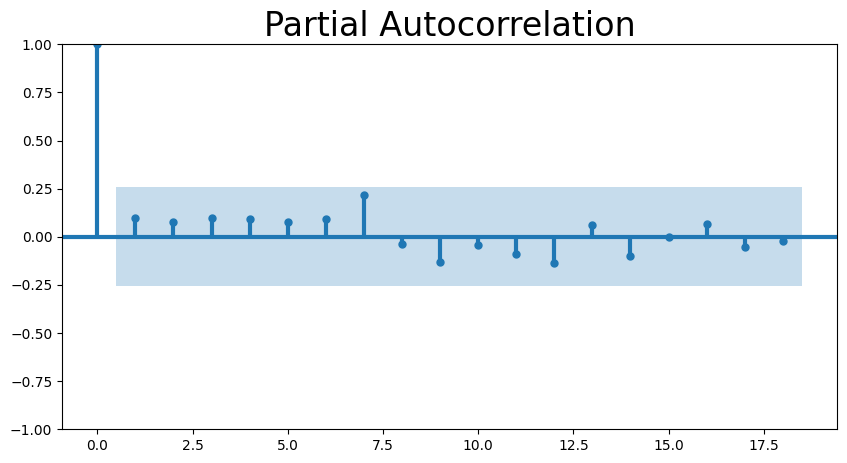

In [228]:
plt.rcParams["figure.figsize"] = 10, 5
plot_pacf(train_df.vol[1:], method="ywm")

По графику не становится очевидным какие параметры p и q выбирать, поскольку границы лагов находятся возле 0, поэтому возьму значения с помощью подбора наименьшего AIC. Могу предположить, что будут лучшими параметрами (1,1)

In [229]:
stat_test(train_df.vol[1:])

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


Временной ряд стационарен, дифференцирование делать не нужно, плэтому параметр d = 0

In [230]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(df["vol"].loc[df.index])
garch_df.loc[train_df.index, "vol"] = train_df["vol"].dropna()

In [231]:
garch_df

,vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


Подберем параметры p и q для модели GARCH, при которых значение AIC будет минимальным

In [232]:
#поищу с помощью цикла, и добавление параметров в список
aic_list = []
for p in range(1,5):
    for q in range(1,5):
        garch = arch_model(garch_df.dropna(),vol='GARCH',p=p,q=q)
        garch_fit = garch.fit(last_obs=garch_df.index[-3])
        aic_list.append((p,q,garch_fit.aic))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

In [233]:
#выберу самые минимальные параметры
best_params = sorted(aic_list,key=lambda x: x[2])[0]
best_params

(1, 1, 461.19562466212255)

Подставлю значения 1 и 1 в параметры p и q модели GARCH

In [234]:
garch = arch_model(garch_df["vol"].dropna(), vol="GARCH",p=1,q=1)
model_results = garch.fit(last_obs=garch_df.index[-3])
model_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Mon, Feb 03 2025   Df Residuals:                       57
Time:                        16:37:46   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

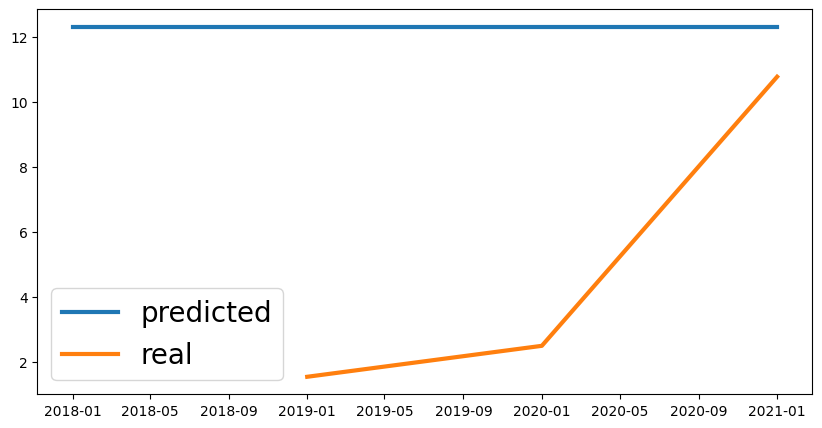

In [235]:
forecasts = model_results.forecast()

#Визуализируем результаты
plt.plot(forecasts.mean, label='predicted')
plt.plot(test_df['vol'], label='real')
plt.legend();


In [176]:
predictions = forecasts.mean.loc[
    test_df.index
]
print('Средняя квадратическая ошибка составляет {:.2f}'.format(mean_squared_error(test_df['vol'],predictions)))

Средняя квадратическая ошибка составляет 71.66


3. Используйте линейную регрессию для получения прогноза.

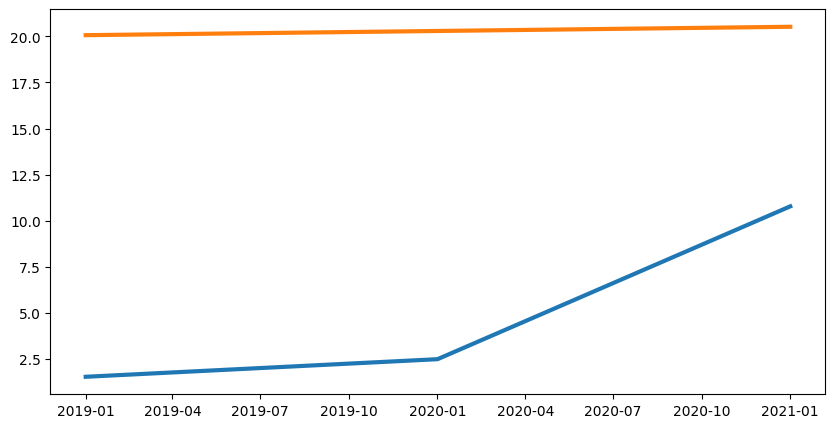

In [177]:
X_train = pd.DataFrame(range(df["vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["vol"].fillna(0)
y_test = test_df["vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [104]:
print('Средняя квадратическая ошибка составляет {:.2f}'.format(mean_squared_error(y_test,lr_predict)))

Средняя квадратическая ошибка составляет 251.41


Обе модели (GARCH и Линейная регрессия) не смогли справиться с обучением данных, но относительно друг друга лучше справилась модель GARCH. Модель GARCH могла не справиться поскольку если ВВП имеют тенденцию к изменению во времени, это может привести к неправильным оценкам волатильности. Также модель скорее всего обучилась под более-менее стабильные данные, а в тестовых данных - был период роста  